
# Singapore Housing Data

## Background

Singapore's lauded public housing-home ownership scheme (BTO scheme) is currently facing many detractors. Recent world events have let to a supply chain issues and a shortage of manpower - all of which are contributing to the shortage of public housing. Even if you were one of the lucky ones to get a coveted BTO, the wait times for construction to be completed can take up to [five years](https://www.channelnewsasia.com/singapore/hdb-bto-flats-projects-median-waiting-time-desmond-lee-delays-2706036).

Given these challenges to buying a home in the primary market (BTOs), many wannabe homeowners are turning to the secondary market - resale flats. But the secondary market has it's own challenges, especially with regards to affordability. Resale prices are rising, and it seems like there is a [record-breaking transaction every other month](https://www.businesstimes.com.sg/property/s15-million-tiong-bahru-hdb-flat-sale-may-marks-new-resale-record-high). There is also a trend of [more home buyers having to pay cash over valuation (COV)](https://www.straitstimes.com/singapore/housing/one-in-four-resale-hdb-flat-buyers-paid-cash-over-valuation-in-2022), given the increased competition for homes. 


### Problem Statement

The goal for this project is to build a model that can calculate/predict the resale price of a HDB unit. This will help future home buyers and home sellers set prices fairly.

The secondary goal for this project is to find out which features most greatly impact the resale price of a HDB unit. This will help future home buyers in managing their expectations and/or requirements given their budget.


## Importing libaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline

## Load the Data


In [2]:
hdb = pd.read_csv('data/train.csv')

/var/folders/5q/pll34czs1rg04zxgqg6sl2qw0000gn/T/ipykernel_2506/1222817387.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb = pd.read_csv('data/train.csv')


## Data Preparation

### Initial cleaning

1. Check for missing values
2. Check for duplicated values
3. Check if datatypes are appropriate for column

In [3]:
hdb.shape

(150634, 77)

In [4]:
# check for nulls

pd.set_option('display.max_rows', 1000)
hdb.isnull().sum()

id                               0
Tranc_YearMonth                  0
town                             0
flat_type                        0
block                            0
street_name                      0
storey_range                     0
floor_area_sqm                   0
flat_model                       0
lease_commence_date              0
resale_price                     0
Tranc_Year                       0
Tranc_Month                      0
mid_storey                       0
lower                            0
upper                            0
mid                              0
full_flat_type                   0
address                          0
floor_area_sqft                  0
hdb_age                          0
max_floor_lvl                    0
year_completed                   0
residential                      0
commercial                       0
market_hawker                    0
multistorey_carpark              0
precinct_pavilion                0
total_dwelling_units

In [5]:
# check duplicated values

hdb.duplicated().value_counts()

False    150634
dtype: int64

In [6]:
# check column data types

hdb.dtypes

id                             int64
Tranc_YearMonth               object
town                          object
flat_type                     object
block                         object
street_name                   object
storey_range                  object
floor_area_sqm               float64
flat_model                    object
lease_commence_date            int64
resale_price                 float64
Tranc_Year                     int64
Tranc_Month                    int64
mid_storey                     int64
lower                          int64
upper                          int64
mid                            int64
full_flat_type                object
address                       object
floor_area_sqft              float64
hdb_age                        int64
max_floor_lvl                  int64
year_completed                 int64
residential                   object
commercial                    object
market_hawker                 object
multistorey_carpark           object
p

#### Initial cleaning observations


|S/N|Observation|Action|
|---|---|---|
|1.|`Tranc_YearMonth` being read in as object. |Should convert to datetime. |
|2.|`postal` being read in as string as some of the cells contain non-numerical values ('NIL'). |Convert 'NIL' values to np.NaN and decide if appropriate to drop rows. |
|3.|Null values in  `Mall_Nearest_Distance`, `Mall_Within_500m`, `Mall_Within_1km`, `Mall_Within_2km`, `Hawker_Within_500m`, `Hawker_Within_1km`, `Hawker_Within_2km` columns. |Decide if appropriate to drop rows or drop columns. |
|4.| Remaining missing values. | Impute missing values with appropriate strategy.


In [7]:
hdb.shape

(150634, 77)

In [8]:
# change 'Tranc_YearMonth' column to datetime

hdb['Tranc_YearMonth'] = pd.to_datetime(hdb['Tranc_YearMonth'])

In [9]:
# change 'postal' column 'NIL' values to np.NaN

hdb['postal'].replace(to_replace = 'NIL', value = np.NaN, inplace=True)

In [10]:
hdb.isnull().sum()

id                               0
Tranc_YearMonth                  0
town                             0
flat_type                        0
block                            0
street_name                      0
storey_range                     0
floor_area_sqm                   0
flat_model                       0
lease_commence_date              0
resale_price                     0
Tranc_Year                       0
Tranc_Month                      0
mid_storey                       0
lower                            0
upper                            0
mid                              0
full_flat_type                   0
address                          0
floor_area_sqft                  0
hdb_age                          0
max_floor_lvl                    0
year_completed                   0
residential                      0
commercial                       0
market_hawker                    0
multistorey_carpark              0
precinct_pavilion                0
total_dwelling_units

Drop rows with NaN values from:

1. `postal` because only 0.02% missing values
2. `Mall_Nearest_Distance` because only 0.6% missing values

In [11]:
# drop rows

hdb.dropna(subset=['postal', 'Mall_Nearest_Distance'], inplace=True)

Do not drop columns; and impute missing values:

Missing values in the `Mall_Within_500m`, `Mall_Within_1km`, `Mall_Within_2km` and `Hawker_Within_500m`, `Hawker_Within_1km`, `Hawker_Within_2km` columns are because nearest mall or hawker are not within the range stated. Based on deductive reasoning, we can impute the missing values with 0. 




In [12]:
# impute missing values with 0

from sklearn.impute import SimpleImputer

imp_zero = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
to_impute = ['Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km']
hdb[to_impute] = imp_zero.fit_transform(hdb[to_impute].values.reshape(-6,6))

In [13]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149772 entries, 0 to 150633
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         149772 non-null  int64         
 1   Tranc_YearMonth            149772 non-null  datetime64[ns]
 2   town                       149772 non-null  object        
 3   flat_type                  149772 non-null  object        
 4   block                      149772 non-null  object        
 5   street_name                149772 non-null  object        
 6   storey_range               149772 non-null  object        
 7   floor_area_sqm             149772 non-null  float64       
 8   flat_model                 149772 non-null  object        
 9   lease_commence_date        149772 non-null  int64         
 10  resale_price               149772 non-null  float64       
 11  Tranc_Year                 149772 non-null  int64   

### Data wrangling

1. Decide which columns to keep and drop, with justification
2. Rearrange or rename columns if necessary
4. Create new columns if necessary
5. Other adjustments to make data ready for machine learning

#### Drop or keep: column observations

|S/N|Columns|Remarks|Drop or keep columns|
|---|---|---|---|
|1.|`id`, `block`, `street_name`, `postal`, `Latitude`, `Longitude`, `address`  `mrt_latitude`, `mrt_longitude`,`bus_stop_name`, `bus_stop_latitude`, `bus_stop_longitude`, `pri_sch_latitude`, `pri_sch_longitude`,`sec_sch_latitude`, `sec_sch_longitude` | Data not necessary for analysis | Drop all columns |
|2.|`storey_range`, `mid_storey`, `lower`, `upper`, `mid` | Provides the same information | Keep `mid_storey` |
|3.|`hdb_age`, `lease_commence_date`, `year_completed` | Provides the same information| Keep `lease_commence_date`|
|4.|`full_flat_type`, `flat_type`, `flat_model` | Provides the same information | Drop `full_flat_type` |
|5.|`Tranc_YearMonth`, `Tranc_Year`, `Tranc_Month` | Provides the same information | Drop `Tranc_YearMonth`|
|6.|`residential`| All values are the same | Drop `residential` |
|7.|`Mall_Nearest_Distance`, `Mall_Within_500m`, `Mall_Within_1km`, `Mall_Within_2km`, `Hawker_Nearest_Distance`, `Hawker_Within_500m`,`Hawker_Within_1km`, `Hawker_Within_2km` | Are related columns | Drop all except `Mall_Nearest_Distance` and `Hawker_Nearest_Distance` |
|8.|`floor_area_sqm`, `floor_area_sqft` | Provides the same information | Keep `floor_area_sqft` |


In [14]:
# drop columns where information is repeated and/or will not be used for analysis

to_drop = ['id', 'Tranc_YearMonth', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'lower', 'upper', 'mid', 'full_flat_type', 'address', 'hdb_age', 'year_completed', 'residential',
           'postal', 'Latitude', 'Longitude', 'Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km', 
           'mrt_latitude', 'mrt_longitude','bus_stop_name', 'bus_stop_latitude', 'bus_stop_longitude', 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_latitude', 'sec_sch_longitude']

hdb.drop(columns = to_drop, inplace=True)

#### Other observations

|S/N|Observations|Actions|
|---|---|---|
|1.|`resale_price` column is positioned somewheere in the middle of the dataframe | Move it to the front for easier visualisation |
|2.|`hdb_age` is the age of the unit at the time the data was collected. More useful would be the age of the unit at the time the transaction was made | Create new column `age_at_tranc` |
|3.|`commercial`, `market_hawker`, `multistorey_carpark`, `precinct_pavilion` have boolean values | Binarise values to optimise for modelling |



In [15]:
# move resale_price column to front for easier visualisation

hdb.insert(0, 'resale_price', hdb.pop('resale_price'))

In [16]:
# hdb age 

hdb['age_at_tranc'] = hdb['Tranc_Year'] - hdb['lease_commence_date']

In [17]:
# binarise Y/N values for ML model

to_binarize = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']

for i in range(0,len(to_binarize)):
    hdb[to_binarize[i]] = hdb[to_binarize[i]].map({'Y': 1, 'N': 0})


In [18]:
# save cleaned data set

hdb.to_pickle('./data/hdb_clean.pkl')

In [19]:
hdb.columns

Index(['resale_price', 'town', 'flat_type', 'flat_model',
       'lease_commence_date', 'Tranc_Year', 'Tranc_Month', 'mid_storey',
       'floor_area_sqft', 'max_floor_lvl', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'planning_area',
       'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
       'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance',
       'mrt_name', 'bus_interchange', 'mrt_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'pri_sch_name',
       'vacancy', 'pri_sch_affiliation', 'sec_sch_nearest_dist',
       'sec_sch_name', 'cutoff_point', 'affiliation', 'age_at_tranc'],
      dtype='object')

## Data Dictionary

|S/N|Column|Description|
|---|---|---|
|1.| `resale_price`| the property's sale price in Singapore dollars. This is the target variable that you're trying to predict for this challenge.|
|2.| `town` |  HDB township where the flat is located, e.g. BUKIT MERAH|
|3.| `flat_type`| type of the resale flat unit, e.g. 3 ROOM|
|4.|`flat_model` | HDB model of the resale flat, e.g. Multi Generation|
|5.| `lease_commence_date`| commencement year of the flat unit's 99-year lease|
|6.|`Tranc_Year`| year of resale transaction|
|7.|`Tranc_Month`| month of resale transaction|
|8.|`mid_storey`| median value of storey_range|
|9.|`floor_area_sqft`| floor area of the resale flat unit in square feet|
|10.|`max_floor_lvl`| highest floor of the resale flat|
|11.|`commercial`| boolean value if resale flat has commercial units in the same block|
|12.|`market_hawker`| boolean value if resale flat has a market or hawker centre in the same block|
|13.|`multistorey_carpark`| boolean value if resale flat has a multistorey carpark in the same block|
|14.|`precinct_pavilion`| boolean value if resale flat has a pavilion in the same block|
|15.|`total_dwelling_units`| total number of residential dwelling units in the resale flat|
|16.|`1room_sold`|number of 1-room residential units in the resale flat|
|17.|`2room_sold`|number of 2-room residential units in the resale flat|
|18.|`3room_sold`|number of 3-room residential units in the resale flat|
|19.|`4room_sold`|number of 4-room residential units in the resale flat|
|20.|`5room_sold`|number of 5-room residential units in the resale flat|
|21.|`exec_sold`|number of executive type residential units in the resale flat|
|22.|`multigen_sold`|number of multigenerational type residential units in the resale flat|
|23.|`studio_apartment_sold`|number of studio apartment type residential units in the resale flat|
|24.|`1room_rental`| number of 1-room rental residential units in the resale flat block|
|25.|`2room_rental`| number of 2-room rental residential units in the resale flat block|
|26.|`3room_rental`| number of 3-room rental residential units in the resale flat block|
|27.|`other_room_rental`| number of 'other' type rental residential units in the resale flat block|
|28.|`planning_area`| Government planning area that the flat is located|
|29.|`Mall_Nearest_Distance`| distance (in metres) to the nearest mall|
|30.|`Hawker_Nearest_Distance`| distance (in metres) to the nearest hawker centre|
|31.|`hawker_food_stalls`| number of hawker food stalls in the nearest hawker centre|
|32.|`hawker_market_stalls`| number of hawker and market stalls in the nearest hawker centre|
|33.|`mrt_nearest_distance`| distance (in metres) to the nearest MRT station|
|34.|`mrt_name`| name of the nearest MRT station|
|35.|`bus_interchange`| boolean value if the nearest MRT station is also a bus interchange|
|36.|`mrt_interchange`| boolean value if the nearest MRT station is a train interchange station|
|37.|`bus_stop_nearest_distance`| distance (in metres) to the nearest bus stop|
|38.|`pri_sch_nearest_distance`| distance (in metres) to the nearest primary school|
|39.|`pri_sch_name`| name of the nearest primary school|
|40.|`vacancy`| number of vacancies in the nearest primary school|
|41.|`pri_sch_affiliation`| boolean value if the nearest primary school has a secondary school affiliation|
|42.|`sec_sch_nearest_dist`| distance (in metres) to the nearest secondary school|
|43.|`sec_sch_name`| name of the nearest secondary school|
|44.|`cutoff_point`| PSLE cutoff point of the nearest secondary school|
|45.|`affiliation`| boolean value if the nearest secondary school has an primary school affiliation|
|46.|`age_at_tranc`| age of unit at the year of transaction|


## Exploratory Data Analysis

### Resale prices: min, max, mean - overall and across different variables

In [20]:
# summary of resale prices

pd.options.display.float_format = '{:,.2f}'.format
hdb['resale_price'].describe()

count     149,772.00
mean      448,661.29
std       143,226.03
min       150,000.00
25%       346,000.00
50%       420,000.00
75%       520,000.00
max     1,258,000.00
Name: resale_price, dtype: float64

In [21]:
# overall min, max, mean resale price

hdb['resale_price'].agg(['min', 'max', 'mean'])

min      150,000.00
max    1,258,000.00
mean     448,661.29
Name: resale_price, dtype: float64

In [22]:
# details of overall min and max

hdb.loc[(hdb['resale_price'] == 150000) | (hdb['resale_price'] == 1258000)].sort_values(by = ['resale_price'])

resale_price          town flat_type flat_model  lease_commence_date  \
81423    150,000.00       GEYLANG    2 ROOM   Standard                 1969   
88670    150,000.00     TOA PAYOH    2 ROOM   Standard                 1983   
82860  1,258,000.00  CENTRAL AREA    5 ROOM    Type S2                 2011   

       Tranc_Year  Tranc_Month  mid_storey  floor_area_sqft  max_floor_lvl  \
81423        2019           10           5           484.38             10   
88670        2020            1           2           462.85             12   
82860        2020            9          44         1,151.75             50   

       ...  bus_stop_nearest_distance  pri_sch_nearest_distance  \
81423  ...                     128.57                    712.13   
88670  ...                      48.03                    349.27   
82860  ...                      83.33                    303.58   

                          pri_sch_name  vacancy  pri_sch_affiliation  \
81423  Canossa Catholic Primary School       47                    1   
88670           Pei Chun Public School       27                    0   
82860        Cantonment Primary School       58                    0   

       sec_sch_nearest_dist              sec_sch_name  cutoff_point  \
81423              1,066.72  Geylang Methodist School           224   
88670                396.50   Beatty Secondary School           211   
82860              1,069.44   Outram Secondary School           188   

       affiliation  age_at_tranc  
81423            0            50  
88670            0            37  
82860            0             9  

[3 rows x 46 columns]

In [23]:
# min, max, mean resale price by town

hdb.groupby('town')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                        
                         min          max       mean
town                                                
ANG MO KIO        178,000.00 1,030,000.00 414,234.22
BEDOK             180,000.00   935,000.00 418,612.02
BISHAN            216,000.00 1,220,000.00 618,458.15
BUKIT BATOK       208,000.00   938,000.00 397,435.62
BUKIT MERAH       157,000.00 1,200,000.00 554,691.48
BUKIT PANJANG     200,000.00   840,000.00 436,062.67
BUKIT TIMAH       300,000.00 1,210,000.00 704,416.88
CENTRAL AREA      200,000.00 1,258,000.00 604,929.86
CHOA CHU KANG     200,000.00   900,000.00 411,896.83
CLEMENTI          205,000.00 1,095,000.00 465,932.50
GEYLANG           150,000.00 1,008,888.00 428,044.83
HOUGANG           195,000.00 1,000,000.00 441,780.10
JURONG EAST       200,000.00   900,000.00 425,700.40
JURONG WEST       175,000.00   790,000.00 412,231.58
KALLANG/WHAMPOA   185,000.00 1,205,000.00 489,030.24
MARINE PARADE     230,000.00   950,000.00 528,395.66
PASIR RIS         215,000.00   860,000.00 500,760.37
PUNGGOL           225,000.00   910,888.00 467,998.23
QUEENSTOWN        182,000.00 1,170,000.00 547,692.35
SEMBAWANG         195,000.00   670,000.00 412,356.40
SENGKANG          206,000.00   750,000.00 457,448.80
SERANGOON         170,000.00 1,020,000.00 487,916.85
TAMPINES          240,000.00   895,000.00 473,755.73
TOA PAYOH         150,000.00 1,150,000.00 475,234.58
WOODLANDS         170,000.00   855,000.00 402,712.31
YISHUN            190,000.00   868,000.00 375,472.45

In [24]:
# min, max, mean resale price by flat type

hdb.groupby('flat_type')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                        
                          min          max       mean
flat_type                                            
1 ROOM             157,000.00   257,000.00 207,015.46
2 ROOM             150,000.00   510,000.00 245,532.25
3 ROOM             170,000.00 1,185,000.00 326,326.80
4 ROOM             218,000.00 1,186,888.00 444,252.97
5 ROOM             270,000.00 1,258,000.00 536,772.50
EXECUTIVE          390,000.00 1,210,000.00 633,933.02
MULTI-GENERATION   600,000.00   980,000.00 767,992.00

In [25]:
# min, max, mean resale price by hdb age at transaction

pd.options.display.float_format = '{:,.2f}'.format

hdb.groupby('age_at_tranc')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                        
                      min          max       mean
age_at_tranc                                     
1              515,000.00   825,000.00 701,205.88
2              360,000.00 1,120,000.00 737,331.95
3              220,000.00 1,200,000.00 499,222.71
4              200,000.00 1,153,000.00 490,925.30
5              195,000.00 1,150,000.00 493,037.43
6              208,000.00 1,180,000.00 544,119.06
7              206,000.00 1,170,000.00 573,198.01
8              210,000.00 1,205,000.00 566,316.19
9              201,300.00 1,258,000.00 566,601.38
10             225,000.00 1,220,000.00 536,641.93
11             225,000.00   950,000.00 516,080.84
12             205,000.00   950,000.00 502,110.71
13             228,000.00   985,000.00 486,762.29
14             285,000.00   955,000.00 477,089.04
15             283,000.00   958,000.00 476,539.14
16             205,000.00   945,000.00 471,511.39
17             208,000.00 1,000,000.00 469,897.57
18             214,000.00   980,000.00 473,245.74
19             190,000.00   990,000.00 476,692.42
20             190,000.00 1,020,000.00 480,358.18
21             216,000.00 1,028,000.00 484,721.74
22             240,000.00 1,160,000.00 484,823.08
23             257,000.00 1,150,000.00 488,612.01
24             242,000.00 1,150,000.00 479,847.07
25             248,500.00 1,055,000.00 479,731.15
26             230,000.00 1,138,800.00 461,811.01
27             235,000.00 1,088,888.00 440,112.49
28             240,000.00 1,050,000.00 439,126.98
29             222,000.00 1,058,000.00 422,003.64
30             210,000.00 1,088,000.00 415,703.97
31             205,000.00 1,138,000.00 413,511.44
32             180,000.00 1,145,000.00 412,026.27
33             178,000.00 1,210,000.00 410,207.83
34             190,000.00 1,065,000.00 406,188.00
35             170,000.00   990,000.00 399,722.50
36             210,000.00   998,000.00 400,356.75
37             150,000.00 1,008,888.00 396,748.50
38             205,000.00   980,000.00 387,534.82
39             188,000.00   910,000.00 380,014.19
40             170,000.00 1,030,000.00 372,897.67
41             180,000.00   993,888.00 369,455.63
42             175,000.00   988,000.00 371,576.18
43             168,000.00 1,060,000.00 364,671.18
44             165,000.00   883,000.00 356,093.10
45             157,000.00 1,053,888.00 346,969.90
46             180,000.00 1,185,000.00 341,757.99
47             160,000.00 1,088,000.00 315,618.12
48             175,000.00 1,000,000.00 297,000.50
49             170,000.00   895,000.00 272,727.39
50             150,000.00   888,000.00 264,151.21
51             160,000.00   850,000.00 260,882.37
52             178,000.00   928,000.00 261,940.25
53             180,000.00   975,000.00 241,389.94
54             215,000.00   310,000.00 247,040.00

In [26]:
# min, max, mean resale price by unit level

hdb.groupby('mid_storey')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                          
                    min          max         mean
mid_storey                                       
2            150,000.00 1,185,000.00   411,853.07
3            245,000.00   860,000.00   430,155.43
5            150,000.00 1,138,800.00   424,820.56
8            165,000.00 1,092,888.00   436,167.85
11           157,000.00 1,128,000.00   447,203.30
13           254,000.00   910,000.00   473,737.78
14           170,000.00 1,210,000.00   487,133.43
17           180,100.00 1,050,000.00   529,232.27
18           273,000.00   895,000.00   554,614.87
20           180,000.00 1,160,000.00   593,598.85
23           205,000.00 1,153,000.00   629,436.60
26           230,000.00 1,210,000.00   673,778.85
28           503,000.00   860,000.00   681,634.07
29           318,000.00 1,220,000.00   747,502.62
32           325,000.00 1,185,000.00   804,075.19
33           705,000.00   708,000.00   706,500.00
35           355,000.00 1,200,000.00   812,364.96
38           360,000.00 1,205,000.00   829,978.80
41           340,000.00 1,232,000.00   880,223.80
44           883,000.00 1,258,000.00 1,016,400.00
47           894,000.00 1,150,000.00 1,018,776.19
50           910,000.00 1,248,000.00 1,052,988.00

In [27]:
# min, max, mean resale price by age at transaction year

hdb.groupby('age_at_tranc')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                        
                      min          max       mean
age_at_tranc                                     
1              515,000.00   825,000.00 701,205.88
2              360,000.00 1,120,000.00 737,331.95
3              220,000.00 1,200,000.00 499,222.71
4              200,000.00 1,153,000.00 490,925.30
5              195,000.00 1,150,000.00 493,037.43
6              208,000.00 1,180,000.00 544,119.06
7              206,000.00 1,170,000.00 573,198.01
8              210,000.00 1,205,000.00 566,316.19
9              201,300.00 1,258,000.00 566,601.38
10             225,000.00 1,220,000.00 536,641.93
11             225,000.00   950,000.00 516,080.84
12             205,000.00   950,000.00 502,110.71
13             228,000.00   985,000.00 486,762.29
14             285,000.00   955,000.00 477,089.04
15             283,000.00   958,000.00 476,539.14
16             205,000.00   945,000.00 471,511.39
17             208,000.00 1,000,000.00 469,897.57
18             214,000.00   980,000.00 473,245.74
19             190,000.00   990,000.00 476,692.42
20             190,000.00 1,020,000.00 480,358.18
21             216,000.00 1,028,000.00 484,721.74
22             240,000.00 1,160,000.00 484,823.08
23             257,000.00 1,150,000.00 488,612.01
24             242,000.00 1,150,000.00 479,847.07
25             248,500.00 1,055,000.00 479,731.15
26             230,000.00 1,138,800.00 461,811.01
27             235,000.00 1,088,888.00 440,112.49
28             240,000.00 1,050,000.00 439,126.98
29             222,000.00 1,058,000.00 422,003.64
30             210,000.00 1,088,000.00 415,703.97
31             205,000.00 1,138,000.00 413,511.44
32             180,000.00 1,145,000.00 412,026.27
33             178,000.00 1,210,000.00 410,207.83
34             190,000.00 1,065,000.00 406,188.00
35             170,000.00   990,000.00 399,722.50
36             210,000.00   998,000.00 400,356.75
37             150,000.00 1,008,888.00 396,748.50
38             205,000.00   980,000.00 387,534.82
39             188,000.00   910,000.00 380,014.19
40             170,000.00 1,030,000.00 372,897.67
41             180,000.00   993,888.00 369,455.63
42             175,000.00   988,000.00 371,576.18
43             168,000.00 1,060,000.00 364,671.18
44             165,000.00   883,000.00 356,093.10
45             157,000.00 1,053,888.00 346,969.90
46             180,000.00 1,185,000.00 341,757.99
47             160,000.00 1,088,000.00 315,618.12
48             175,000.00 1,000,000.00 297,000.50
49             170,000.00   895,000.00 272,727.39
50             150,000.00   888,000.00 264,151.21
51             160,000.00   850,000.00 260,882.37
52             178,000.00   928,000.00 261,940.25
53             180,000.00   975,000.00 241,389.94
54             215,000.00   310,000.00 247,040.00

In [28]:
# min, max, mean resale price by transaction year

hdb.groupby('Tranc_Year')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                        
                    min          max       mean
Tranc_Year                                     
2012         209,000.00 1,010,000.00 464,528.41
2013         208,000.00 1,050,000.00 476,054.39
2014         195,000.00 1,088,888.00 443,264.22
2015         195,000.00 1,088,000.00 434,263.46
2016         190,000.00 1,100,000.00 438,583.04
2017         175,000.00 1,180,000.00 444,508.15
2018         160,000.00 1,185,000.00 441,142.86
2019         150,000.00 1,205,000.00 432,384.07
2020         150,000.00 1,258,000.00 451,070.82
2021         180,000.00 1,220,000.00 488,218.75

In [29]:
# is there a difference in resale prices if the block has rental units?

print("With rental units")
print(hdb[(hdb['1room_rental'] > 0) | (hdb['2room_rental'] > 0) | (hdb['3room_rental'] > 0) | (hdb['other_room_rental'] > 0)]['resale_price'].agg(['min', 'max', 'mean']))

print("\nWithout rental units")
print(hdb[(hdb['1room_rental'] == 0) & (hdb['2room_rental'] == 0) & (hdb['3room_rental'] == 0) & (hdb['other_room_rental'] == 0)]['resale_price'].agg(['min', 'max', 'mean']))

With rental units
min    150,000.00
max    985,000.00
mean   318,222.94
Name: resale_price, dtype: float64

Without rental units
min      160,000.00
max    1,258,000.00
mean     453,648.93
Name: resale_price, dtype: float64


### Floor area: min, max, mean - overall and across different variables

In [30]:
# summary of floor area

hdb['floor_area_sqft'].describe()

count   149,772.00
mean      1,046.53
std         263.08
min         333.68
25%         807.30
50%       1,022.58
75%       1,205.57
max       3,013.92
Name: floor_area_sqft, dtype: float64

In [31]:
# overall min, max, mean

hdb['floor_area_sqft'].agg(['min','max', 'mean'])

min      333.68
max    3,013.92
mean   1,046.53
Name: floor_area_sqft, dtype: float64

In [32]:
floor_area = hdb.loc[(hdb['floor_area_sqft'] == 333.684) | (hdb['floor_area_sqft'] == 3013.92)].sort_values(by = ['resale_price'])

In [33]:
# where are the smallest and biggests flats located?

floor_area.groupby(['floor_area_sqft', 'town'])[['town']].agg('count')

town
floor_area_sqft town                 
333.68          BUKIT MERAH        82
3,013.92        KALLANG/WHAMPOA     1

In [34]:
# what are the resale prices for the smallest and biggest flats?

floor_area.groupby('floor_area_sqft')[['resale_price']].agg(['min', 'max', 'mean'])

resale_price                          
                         min          max         mean
floor_area_sqft                                       
333.68            157,000.00   257,000.00   207,015.46
3,013.92        1,060,000.00 1,060,000.00 1,060,000.00

In [35]:
# min, max, mean floor area by location

hdb.groupby('town')[['floor_area_sqft']].agg(['min', 'max', 'mean'])

floor_area_sqft                  
                            min      max     mean
town                                             
ANG MO KIO               473.62 1,915.99   898.20
BEDOK                    473.62 1,894.46   951.67
BISHAN                   678.13 2,615.65 1,146.88
BUKIT BATOK              635.08 1,776.06 1,009.30
BUKIT MERAH              333.68 1,689.95   925.61
BUKIT PANJANG            495.14 1,668.42 1,113.10
BUKIT TIMAH              678.13 1,657.66 1,183.63
CENTRAL AREA             441.32 1,496.20   865.81
CHOA CHU KANG            495.14 2,314.26 1,193.14
CLEMENTI                 473.62 1,754.53   910.76
GEYLANG                  430.56 1,722.24   879.11
HOUGANG                  505.91 1,905.23 1,085.54
JURONG EAST              462.85 1,862.17 1,039.40
JURONG WEST              398.27 1,711.48 1,100.96
KALLANG/WHAMPOA          452.09 3,013.92   917.51
MARINE PARADE            452.09 1,582.31   915.12
PASIR RIS                505.91 2,045.16 1,304.84
PUNGGOL                  473.62 1,603.84 1,059.19
QUEENSTOWN               452.09 1,679.18   867.79
SEMBAWANG                430.56 1,539.25 1,139.48
SENGKANG                 473.62 1,560.78 1,091.18
SERANGOON                473.62 1,776.06 1,071.34
TAMPINES                 484.38 1,808.35 1,121.94
TOA PAYOH                409.03 1,786.82   918.15
WOODLANDS                484.38 2,066.69 1,152.60
YISHUN                   430.56 2,012.87   993.36

In [36]:
# min, max, mean floor area by flat type

hdb.groupby('flat_type')[['floor_area_sqft']].agg(['min', 'max', 'mean'])

floor_area_sqft                  
                             min      max     mean
flat_type                                         
1 ROOM                    333.68   333.68   333.68
2 ROOM                    365.98   721.19   492.77
3 ROOM                    527.44 3,013.92   734.13
4 ROOM                    753.48 1,560.78 1,029.72
5 ROOM                  1,065.64 1,722.24 1,272.50
EXECUTIVE               1,334.74 2,615.65 1,551.62
MULTI-GENERATION        1,420.85 1,926.76 1,735.69

### Flat type: most and least common flat types, and their locations

In [37]:
# most and least common flat types

hdb['flat_type'].value_counts()

4 ROOM              60637
3 ROOM              38905
5 ROOM              36219
EXECUTIVE           11986
2 ROOM               1887
1 ROOM                 82
MULTI-GENERATION       56
Name: flat_type, dtype: int64

In [38]:
# where are these flats located?

hdb.groupby(['flat_type', 'town'])[['town']].agg('count')

town
flat_type        town                 
1 ROOM           BUKIT MERAH        82
2 ROOM           ANG MO KIO        147
                 BEDOK             132
                 BUKIT MERAH       208
                 BUKIT PANJANG      45
                 CENTRAL AREA       60
                 CHOA CHU KANG      31
                 CLEMENTI           28
                 GEYLANG           157
                 HOUGANG            36
                 JURONG EAST        38
                 JURONG WEST        86
                 KALLANG/WHAMPOA    80
                 MARINE PARADE       5
                 PASIR RIS          18
                 PUNGGOL           126
                 QUEENSTOWN        161
                 SEMBAWANG          51
                 SENGKANG          154
                 SERANGOON          19
                 TAMPINES           36
                 TOA PAYOH         145
                 WOODLANDS          56
                 YISHUN             68
3 ROOM           ANG MO KIO       3960
                 BEDOK            4004
                 BISHAN            354
                 BUKIT BATOK      2173
                 BUKIT MERAH      2190
                 BUKIT PANJANG     664
                 BUKIT TIMAH        71
                 CENTRAL AREA      537
                 CHOA CHU KANG     352
                 CLEMENTI         1942
                 GEYLANG          1887
                 HOUGANG          1665
                 JURONG EAST      1284
                 JURONG WEST      2219
                 KALLANG/WHAMPOA  2054
                 MARINE PARADE     482
                 PASIR RIS          69
                 PUNGGOL           471
                 QUEENSTOWN       1963
                 SEMBAWANG          69
                 SENGKANG          529
                 SERANGOON         764
                 TAMPINES         2417
                 TOA PAYOH        2258
                 WOODLANDS        1369
                 YISHUN           3158
4 ROOM           ANG MO KIO       1821
                 BEDOK            2969
                 BISHAN           1398
                 BUKIT BATOK      2212
                 BUKIT MERAH      2095
                 BUKIT PANJANG    2648
                 BUKIT TIMAH       128
                 CENTRAL AREA      481
                 CHOA CHU KANG    3041
                 CLEMENTI         1150
                 GEYLANG          1300
                 HOUGANG          3391
                 JURONG EAST       997
                 JURONG WEST      4243
                 KALLANG/WHAMPOA  1323
                 MARINE PARADE     243
                 PASIR RIS        1958
                 PUNGGOL          3960
                 QUEENSTOWN       1358
                 SEMBAWANG        1618
                 SENGKANG         5381
                 SERANGOON        1375
                 TAMPINES         4215
                 TOA PAYOH        1433
                 WOODLANDS        5055
                 YISHUN           4844
5 ROOM           ANG MO KIO        891
                 BEDOK            1500
                 BISHAN            826
                 BUKIT BATOK       738
                 BUKIT MERAH      1259
                 BUKIT PANJANG    1687
                 BUKIT TIMAH        87
                 CENTRAL AREA      171
                 CHOA CHU KANG    2075
                 CLEMENTI          390
                 GEYLANG           476
                 HOUGANG          1572
                 JURONG EAST       806
                 JURONG WEST      3619
                 KALLANG/WHAMPOA   791
                 MARINE PARADE     229
                 PASIR RIS        1487
                 PUNGGOL          2794
                 QUEENSTOWN        540
                 SEMBAWANG        1347
                 SENGKANG         3842
                 SERANGOON         524
                 TAMPINES         2729
                 TOA PAYOH         847
                 WOODLANDS        3570
                 

### HDB age at transaction: mode, min, max, mean - overall and across flat types

In [39]:
# mode of overall hdb age at transaction year

age = hdb['age_at_tranc'].value_counts().reset_index()
age.rename(columns = {'index' : 'age_at_tranc', 'age_at_tranc' : 'frequency'}, inplace=True)
age[0:5]

age_at_tranc  frequency
0             4       5937
1             5       5209
2            33       5016
3            32       5011
4            31       4961

In [40]:
# min, max, mean of overall hdb age at transaction year

hdb['age_at_tranc'].agg(['min', 'max', 'mean'])

min     1.00
max    54.00
mean   24.15
Name: age_at_tranc, dtype: float64

In [41]:
# mode of hdb age at transaction year by flat type

hdb.groupby('flat_type')['age_at_tranc'].value_counts()

flat_type         age_at_tranc
1 ROOM            39                19
                  37                11
                  44                 9
                  42                 8
                  45                 8
                  40                 7
                  43                 7
                  38                 5
                  41                 4
                  46                 4
2 ROOM            5                228
                  4                184
                  6                142
                  7                 73
                  42                69
                  45                67
                  43                61
                  50                59
                  41                58
                  46                58
                  47                57
                  35                56
                  48                53
                  49                51
                  34             

In [42]:
# min, max, mean of hdb age at transaction year by flat type

hdb.groupby('flat_type')['age_at_tranc'].agg(['min', 'max', 'mean'])

min  max  mean
flat_type                       
1 ROOM             37   46 40.96
2 ROOM              2   54 27.14
3 ROOM              1   54 33.45
4 ROOM              1   53 20.91
5 ROOM              1   50 19.88
EXECUTIVE           8   43 22.67
MULTI-GENERATION   24   34 29.66

### Transaction year: most and least transactions

In [43]:
# which years had the most and least transactions

hdb['Tranc_Year'].value_counts()

2020    18613
2019    18017
2018    17535
2017    16671
2012    16174
2016    15618
2015    14307
2013    13083
2014    12981
2021     6773
Name: Tranc_Year, dtype: int64

## Data Visualisations

### Distribution of resale price, floor area, HDB age at transaction

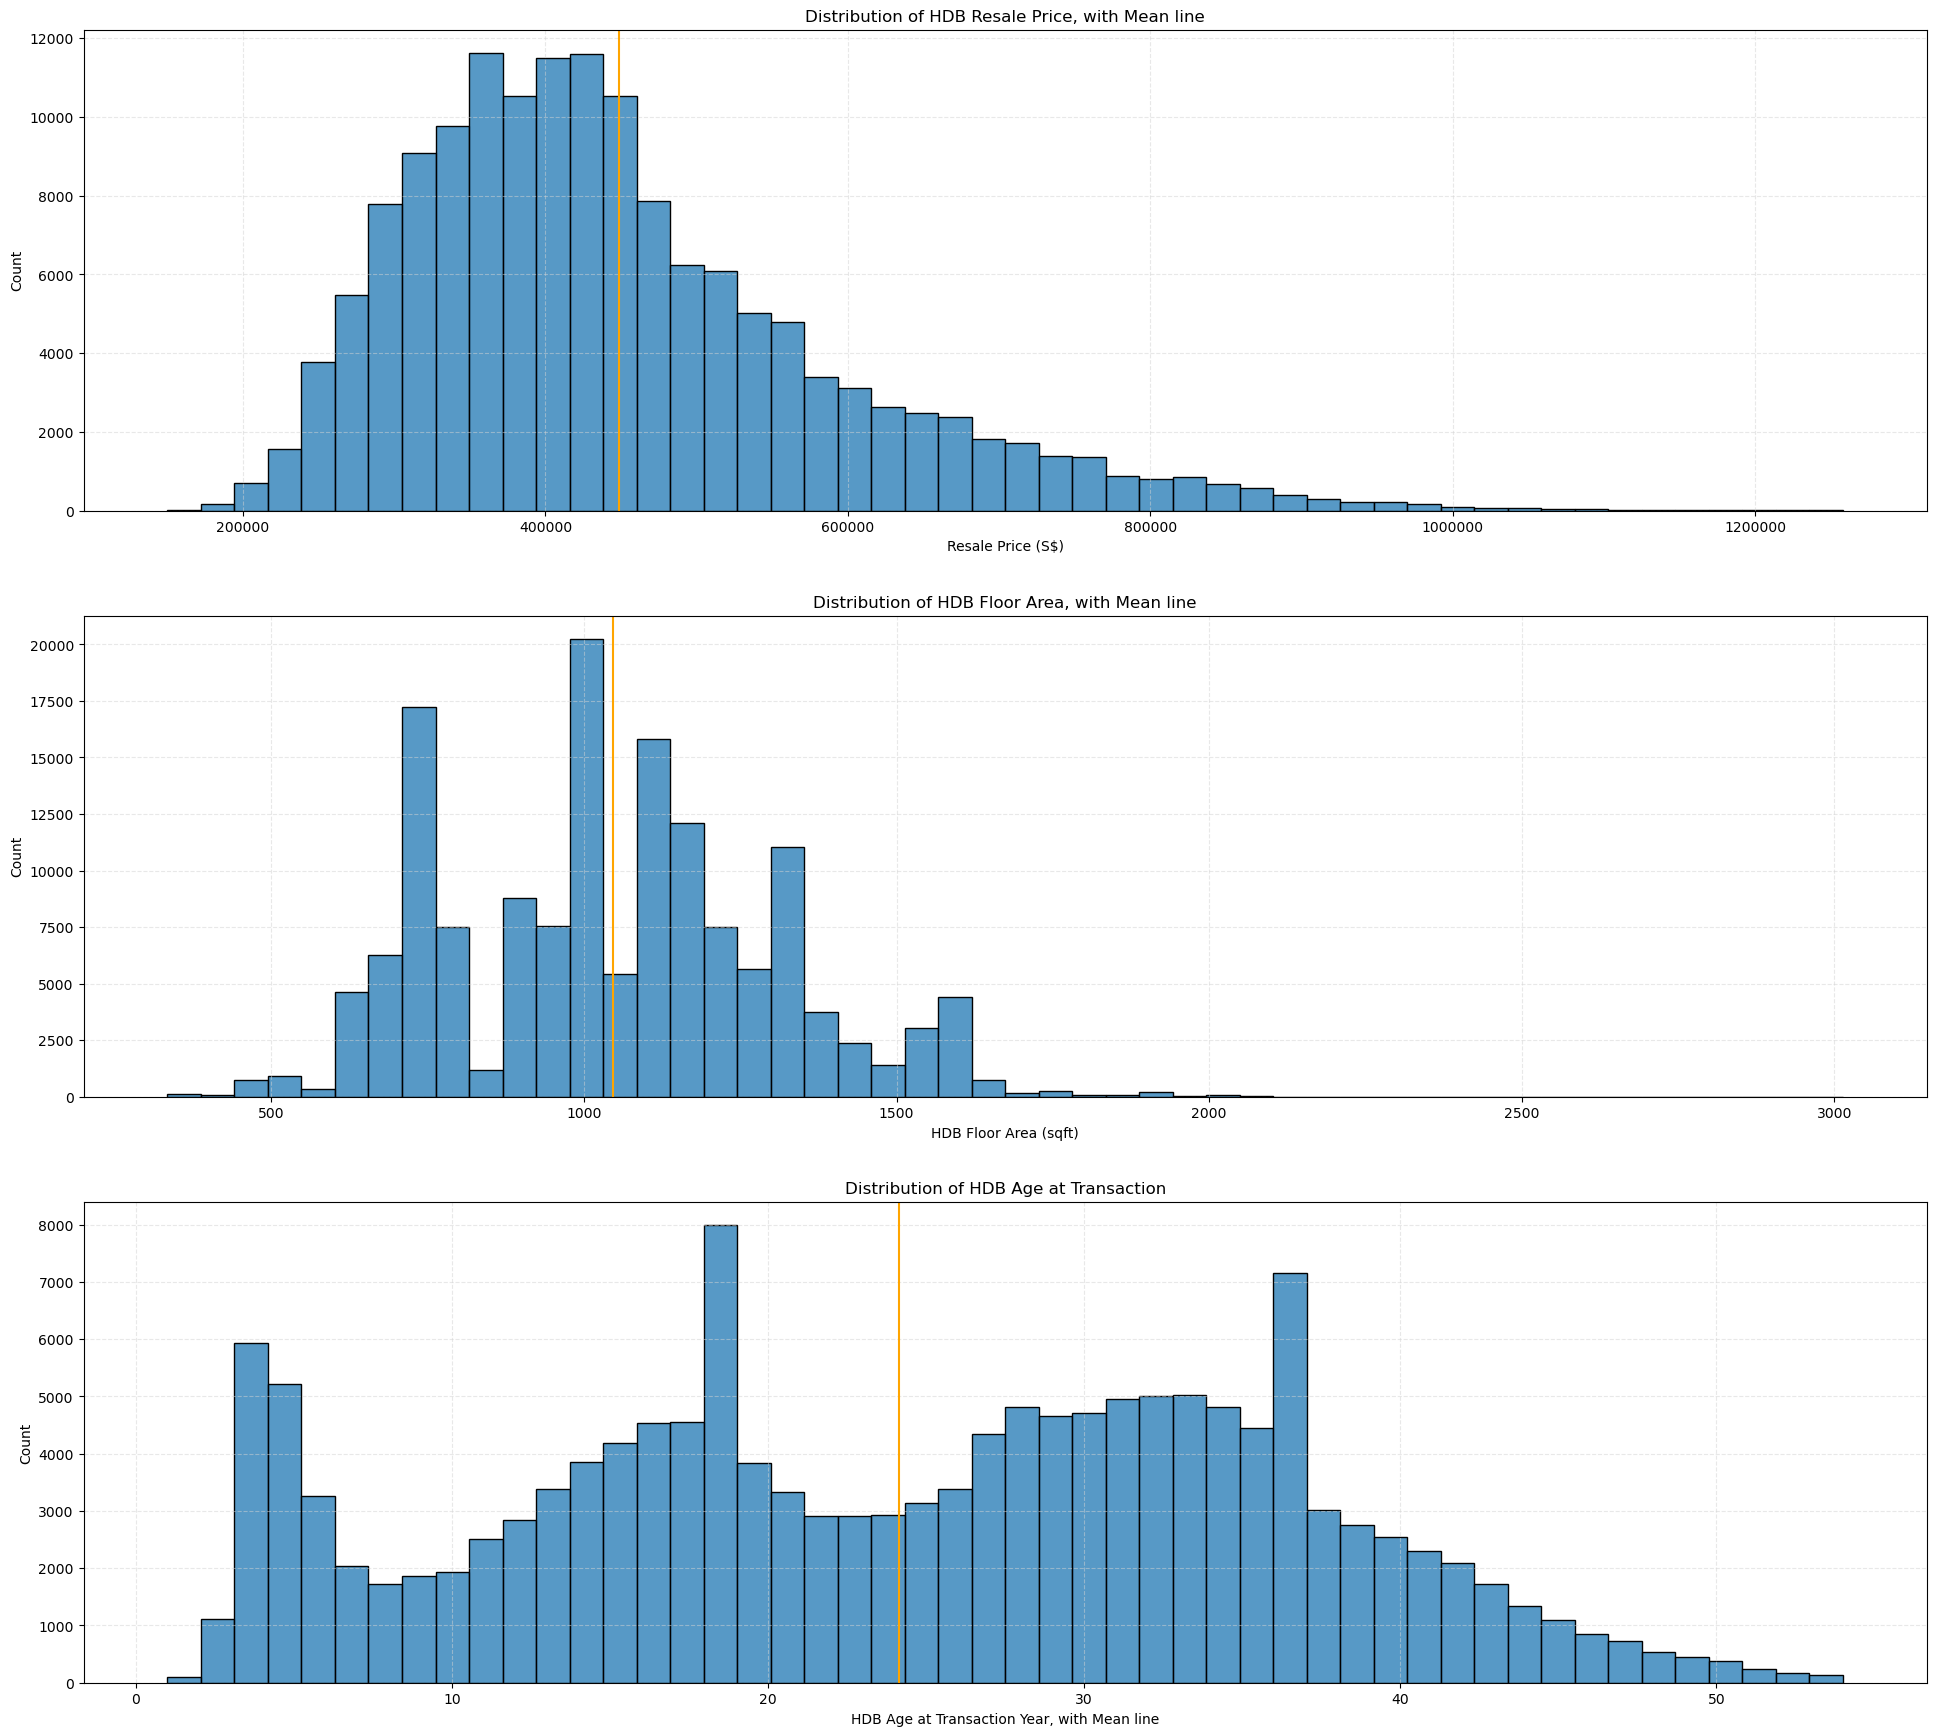

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18))

sns.histplot(data=hdb, x='resale_price', bins = 50, ax=axes[0])
axes[0].set_title('Distribution of HDB Resale Price, with Mean line')
axes[0].set_xlabel('Resale Price (S$)')
axes[0].ticklabel_format(style='plain')
axes[0].axvline(x=448661.29, color='orange')
axes[0].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)

sns.histplot(data=hdb, x='floor_area_sqft', bins = 50, ax=axes[1])
axes[1].set_title('Distribution of HDB Floor Area, with Mean line')
axes[1].set_xlabel('HDB Floor Area (sqft)')
axes[1].axvline(x=1046.53, color='orange')
axes[1].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)
                   
sns.histplot(data=hdb, x='age_at_tranc', bins = 50, ax=axes[2])
axes[2].set_title('Distribution of HDB Age at Transaction')
axes[2].set_xlabel('HDB Age at Transaction Year, with Mean line')
axes[2].axvline(x=24.15, color='orange')
axes[2].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


plt.tight_layout(pad=3.0)




**Distribution of Resale Price Data**
- Positively skewed
- Values range from S\\$150,000 to S\\$1,258,000
- Mean value is S$448,661
- Presence of outliers

**Distribution of Floor Area Data**
- Random distribution with no apparent pattern
- Values range from 333.68 sqft to 3013.92 sqft
- Mean value is 1046.53 sqft
- Presence of outliers

**Distribution of Age at Transaction Data**
- Random distribution with no apparent pattern
- Values range from 1 year to 54 years
- Mean value is 24.15 years
- No presence of outliers


**Note:** We will retain the outliers in the dataset, as they represent rare/unusual events that would be useful for our analysis of HDB resale prices.

### Relationship between resale price and town

The top three towns with the highest average resale prices are:
1. Bukit Timah (S\\$704,416.88)
2. Bishan (S\\$618,458.15)
3. Central Area (S\\$604,929.86)

While the top three towns with the lowest average resale prices are:
1. Yishun (S\\$375,472.45)
2. Bukit Batok (S\\$397,435.62)
3. Woodlands (S\\$402,712.31)

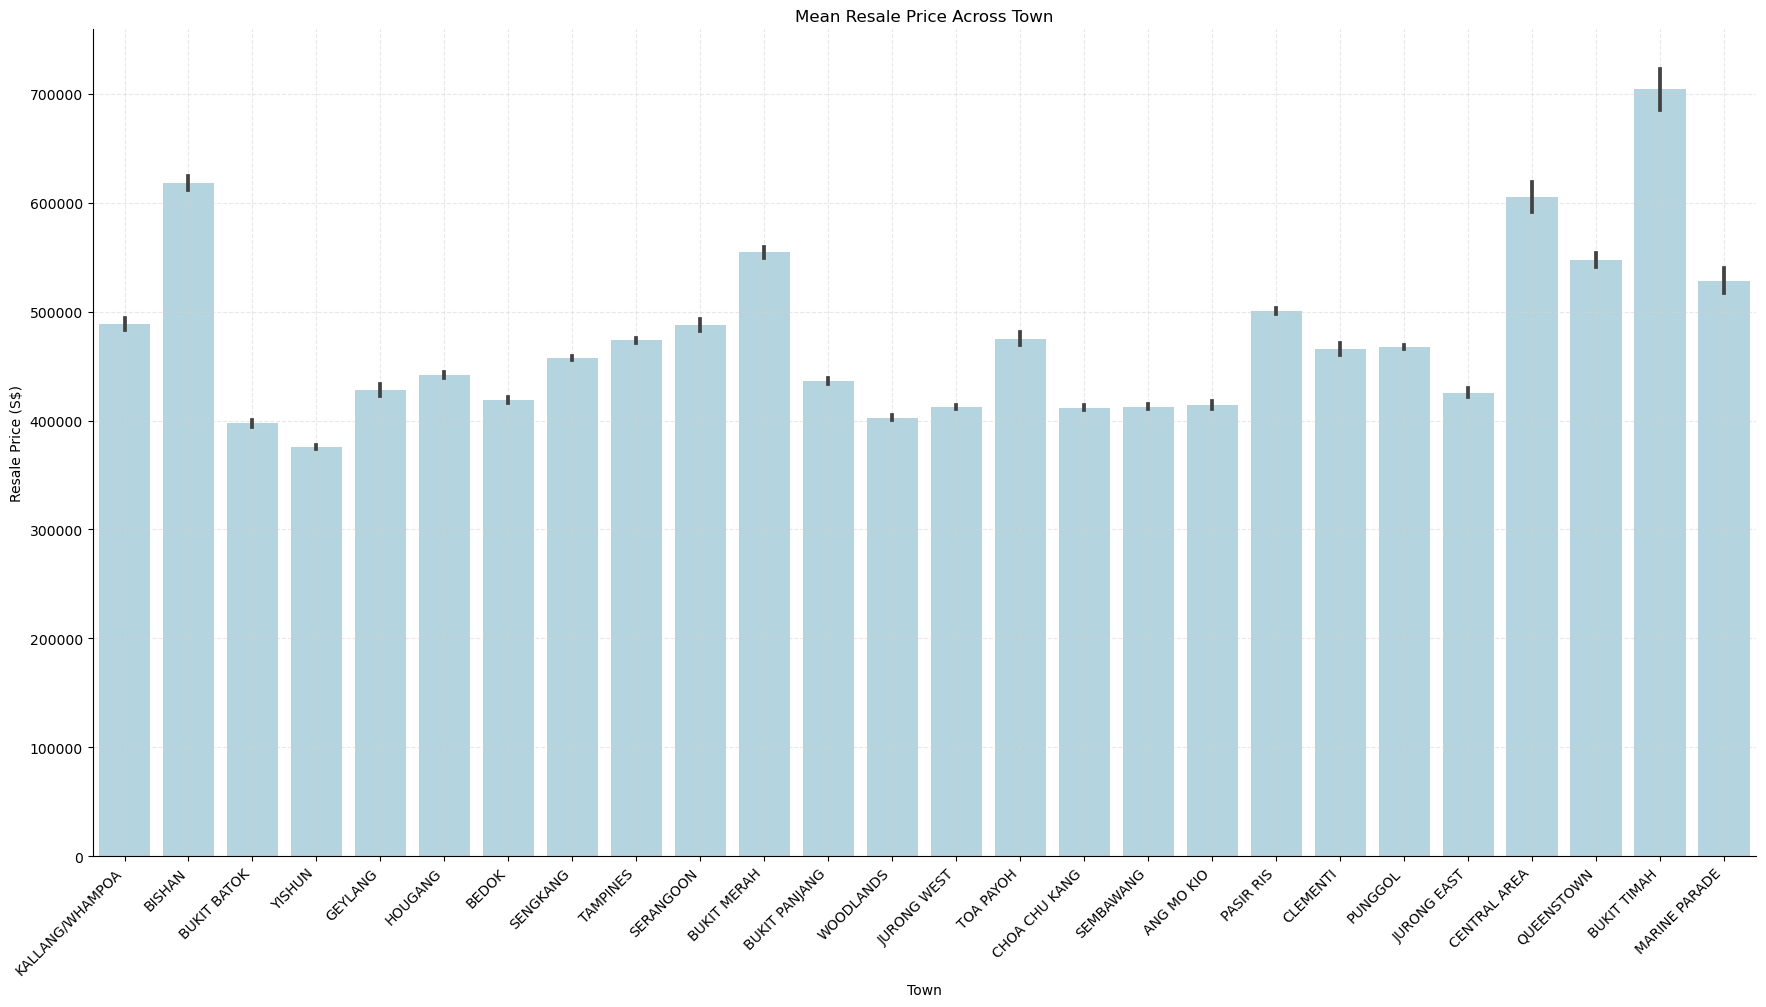

In [45]:
sns.catplot(data=hdb, x='town', y='resale_price', kind='bar', color='lightblue', height=9, aspect=2)

plt.title('Mean Resale Price Across Town')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Town')
tick_positions = plt.xticks()[0]
tick_labels = hdb['town'].unique()
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


### Relationship between resale price and floor area

In general, there is a positive relationship between resale price and floor area. The larger the floor area, the greater the resale price.
<br>However, there are certain units which are at the 99th-percentile of resale price, but are only at about the 60-70th-percentile of floor area.
<br> This indicates that there could be other features that have a greater importance on resale price.

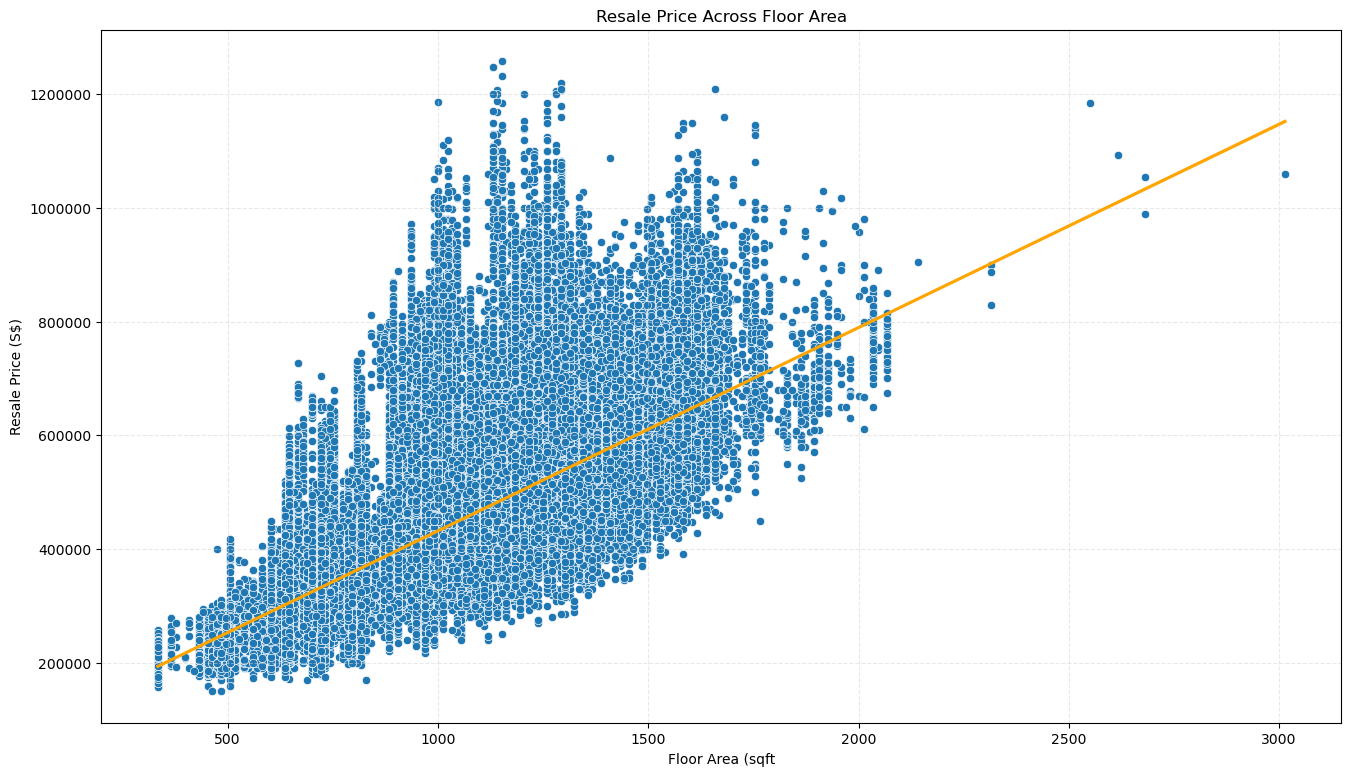

In [46]:
plt.figure(figsize=(16, 9))

sns.scatterplot(data=hdb, x='floor_area_sqft', y='resale_price')
sns.regplot(data=hdb, x='floor_area_sqft', y='resale_price', scatter=False, color='orange')

plt.title('Resale Price Across Floor Area')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Floor Area (sqft')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


### Relationship between resale price and accessibility

In general, there is an inverse relationship between resale price and distance to nearest MRT, with resale prices getting higher the nearer it is to an MRT station. However, there seems to be no relationship between resale price and distance to the nearest bus stop.

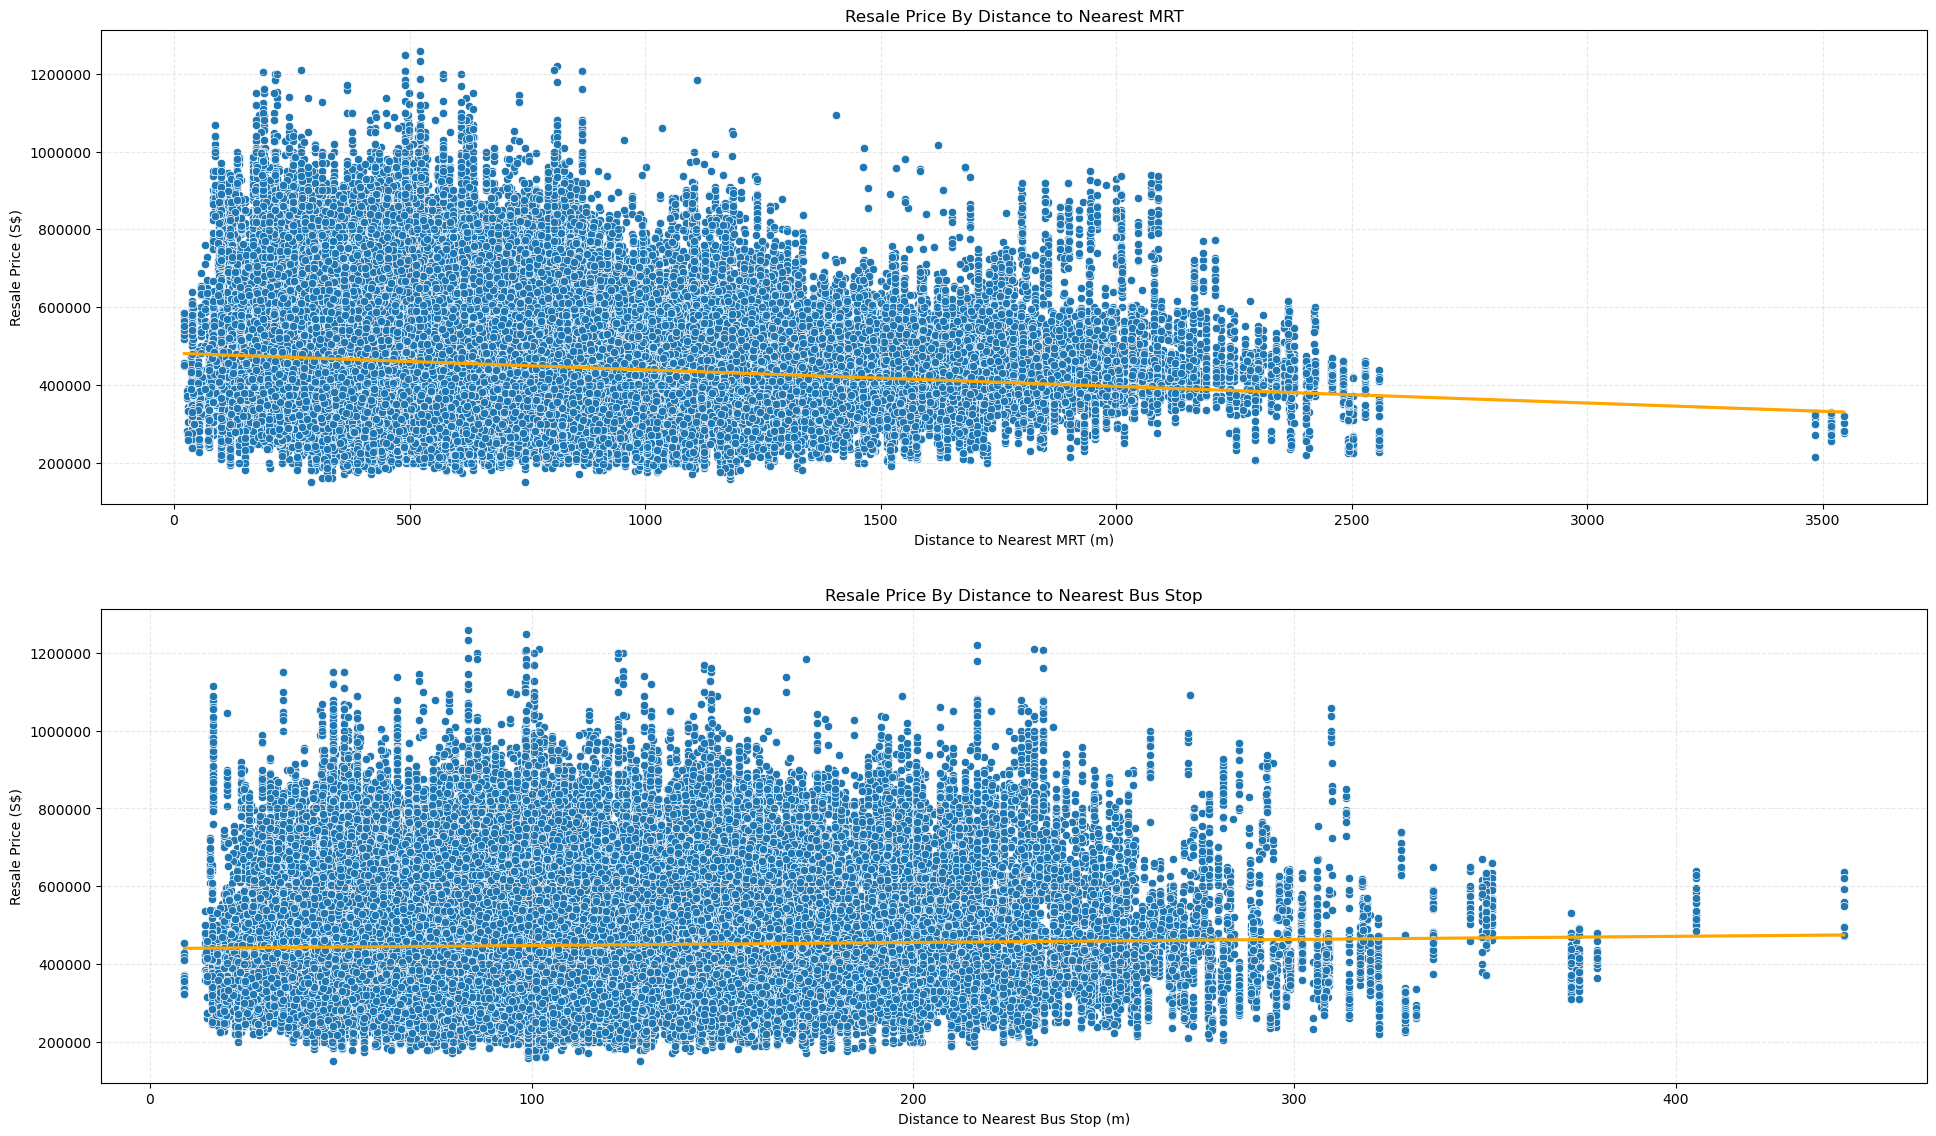

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

sns.scatterplot(data=hdb, x='mrt_nearest_distance', y='resale_price', ax=axes[0]);
sns.regplot(data=hdb, x='mrt_nearest_distance', y='resale_price', scatter=False, color='orange', ax=axes[0])
axes[0].set_title('Resale Price By Distance to Nearest MRT')
axes[0].set_ylabel('Resale Price (S$)')
axes[0].set_xlabel('Distance to Nearest MRT (m)')
axes[0].ticklabel_format(style='plain')
axes[0].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)

sns.scatterplot(data=hdb, x='bus_stop_nearest_distance', y='resale_price', ax=axes[1]);
sns.regplot(data=hdb, x='bus_stop_nearest_distance', y='resale_price', scatter=False, color='orange', ax=axes[1])
axes[1].set_title('Resale Price By Distance to Nearest Bus Stop')
axes[1].set_ylabel('Resale Price (S$)')
axes[1].set_xlabel('Distance to Nearest Bus Stop (m)')
axes[1].ticklabel_format(style='plain')
axes[1].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


plt.tight_layout(pad=3.0)


### Relationship between resale price and amenities

In general, there is very slight inverse relationship between resale price and distance to nearest mall, with resale prices getting higher the nearer it is to a mall. However, there seems to be no relationship between resale price and distance to the nearest hawker.

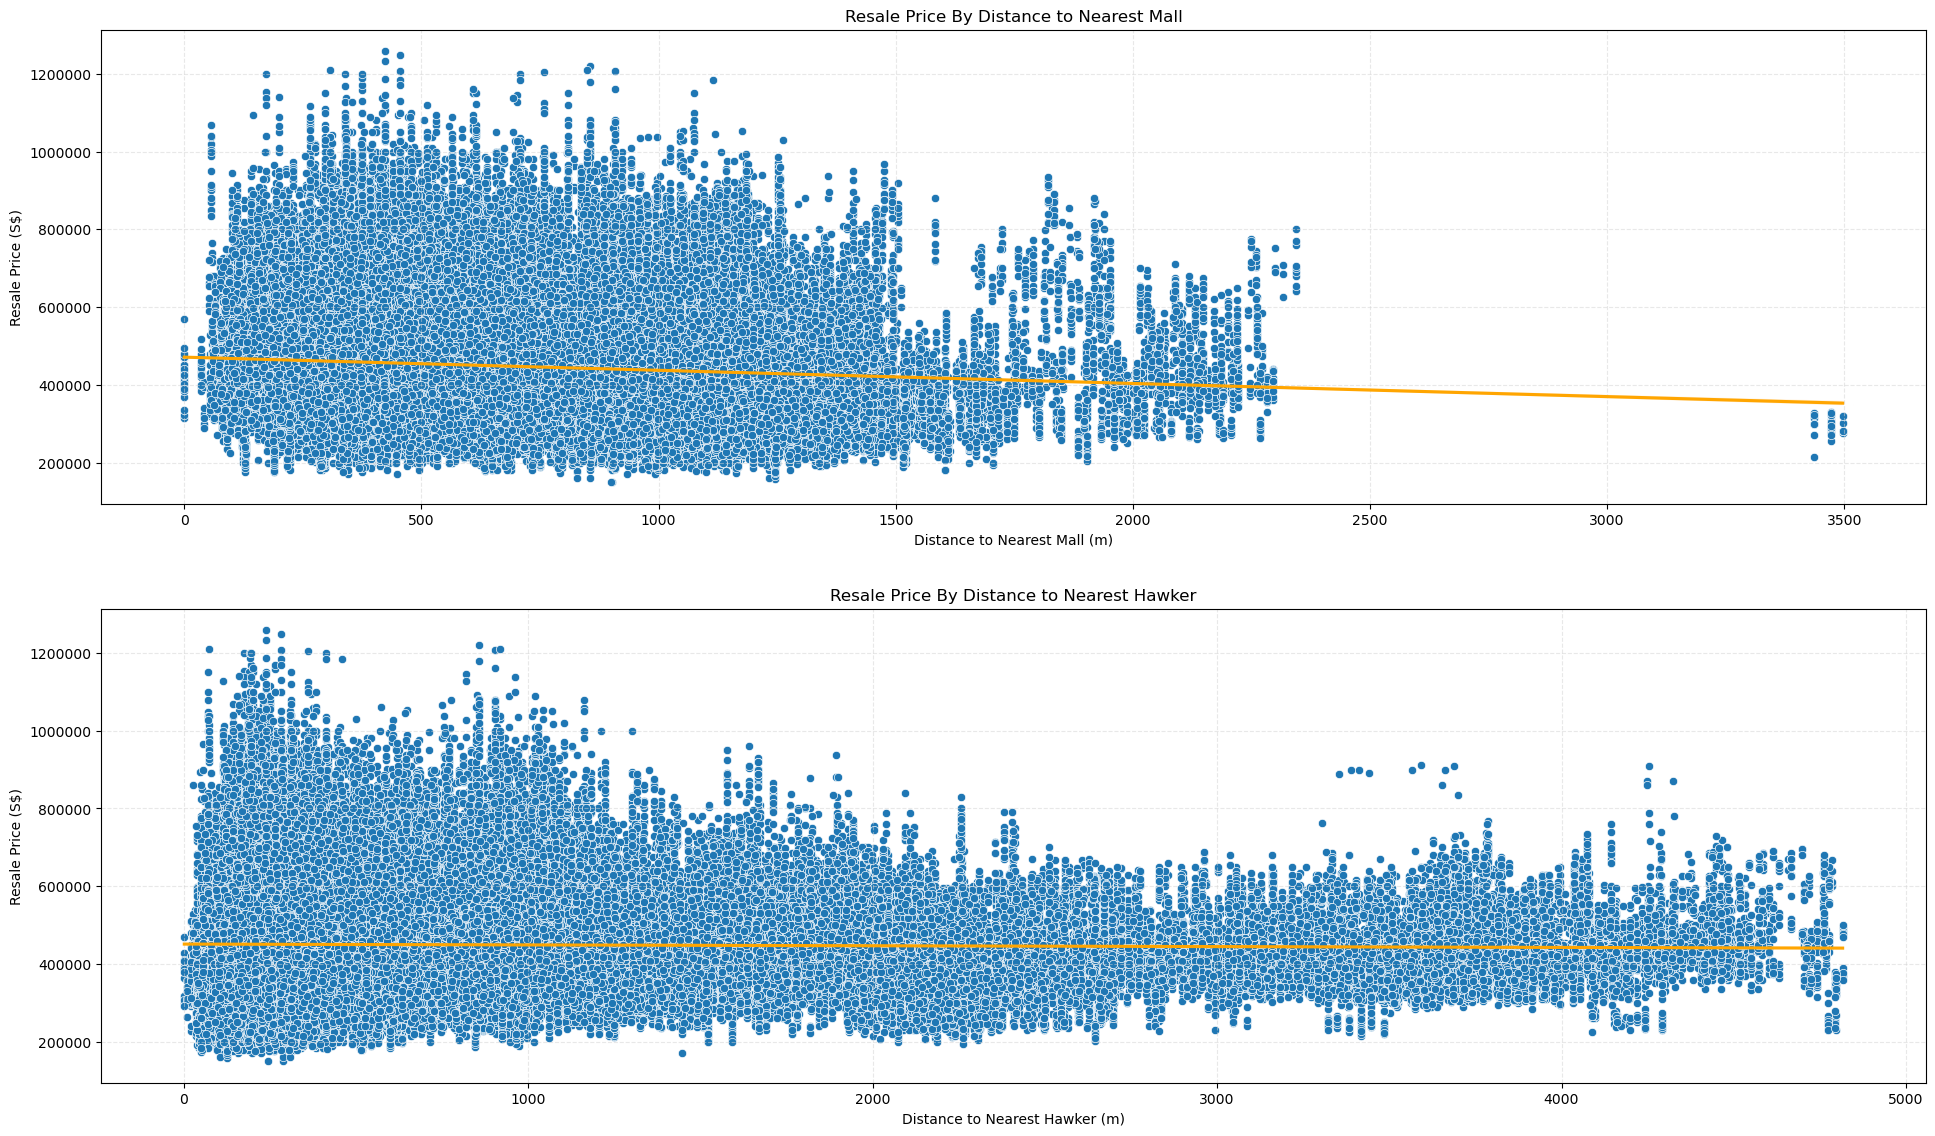

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

sns.scatterplot(data=hdb, x='Mall_Nearest_Distance', y='resale_price', ax=axes[0]);
sns.regplot(data=hdb, x='Mall_Nearest_Distance', y='resale_price', scatter=False, color='orange', ax=axes[0])
axes[0].set_title('Resale Price By Distance to Nearest Mall')
axes[0].set_ylabel('Resale Price (S$)')
axes[0].set_xlabel('Distance to Nearest Mall (m)')
axes[0].ticklabel_format(style='plain')
axes[0].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


sns.scatterplot(data=hdb, x='Hawker_Nearest_Distance', y='resale_price', ax=axes[1]);
sns.regplot(data=hdb, x='Hawker_Nearest_Distance', y='resale_price', scatter=False, color='orange', ax=axes[1])
axes[1].set_title('Resale Price By Distance to Nearest Hawker')
axes[1].set_ylabel('Resale Price (S$)')
axes[1].set_xlabel('Distance to Nearest Hawker (m)')
axes[1].ticklabel_format(style='plain')
axes[1].grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


plt.tight_layout(pad=3.0)


### Relationship between resale price and year of transaction

In general, the average resale price from 2012 to 2021 is quite uniform, ranging between S\\$430,000 to S\\$490,000 year to year.

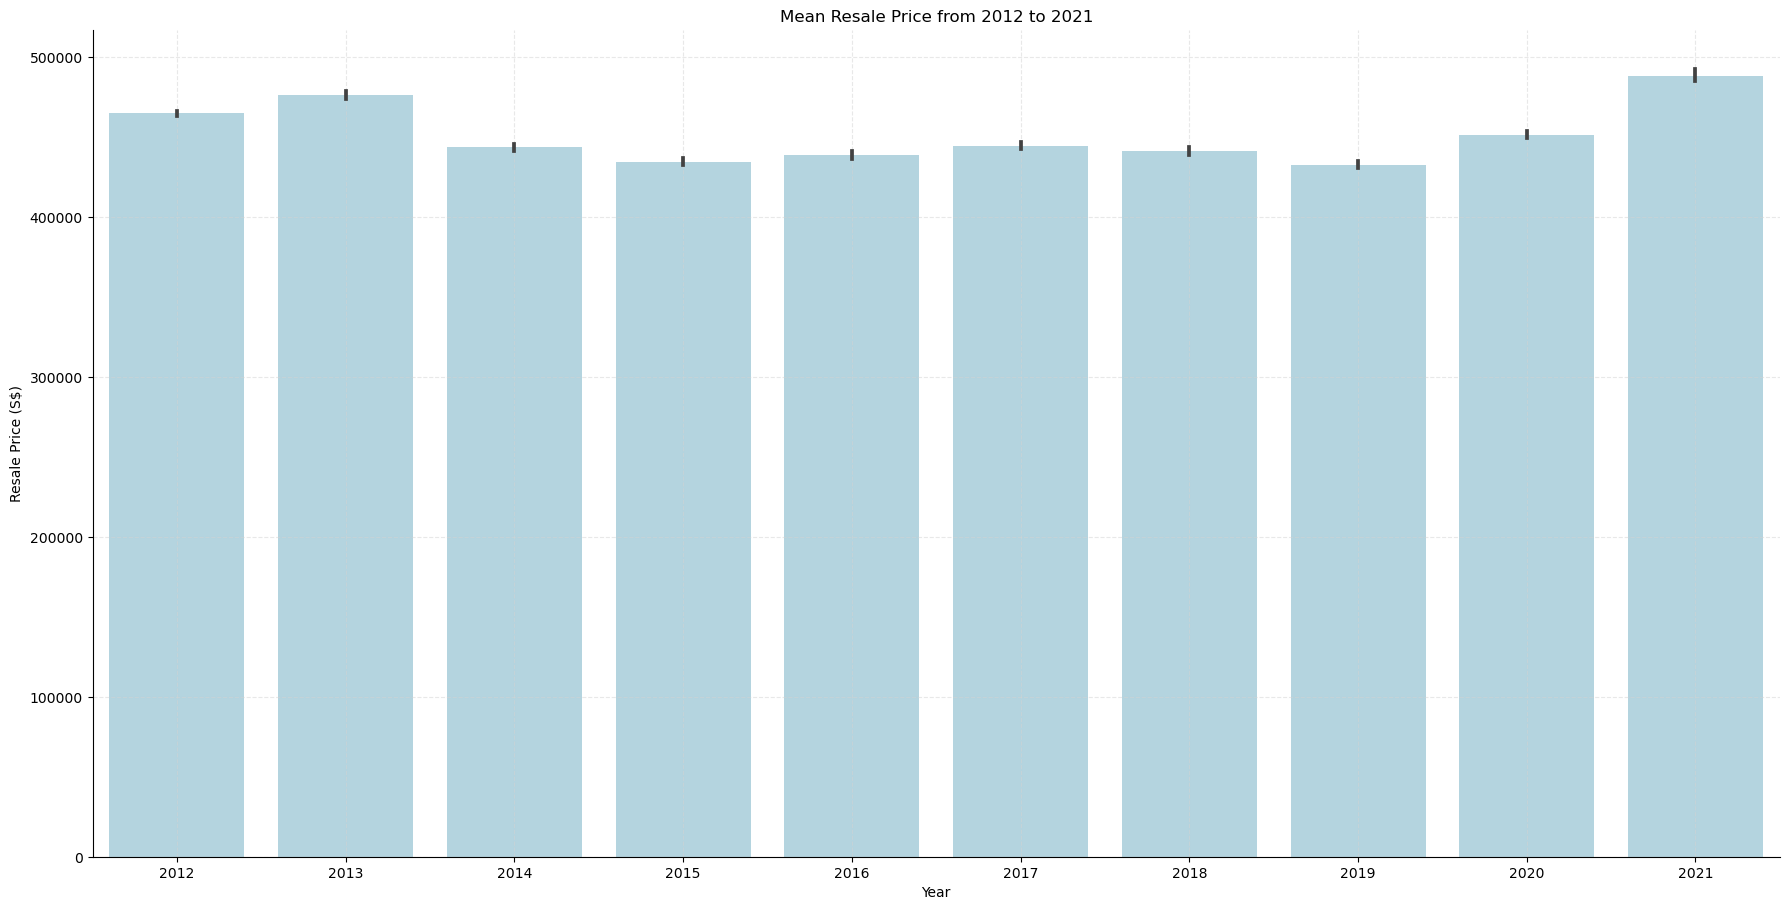

In [49]:
sns.catplot(data=hdb, x='Tranc_Year', y='resale_price', kind='bar', color='lightblue', height=9, aspect=2)

plt.title('Mean Resale Price from 2012 to 2021')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Year')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


### Relationship between resale price and unit level

In general, there is a positive relationship between resale price and unit level, with the resale price increasing as the unit level increases.
<br> This is true for all levels except for units on the 33-floor.

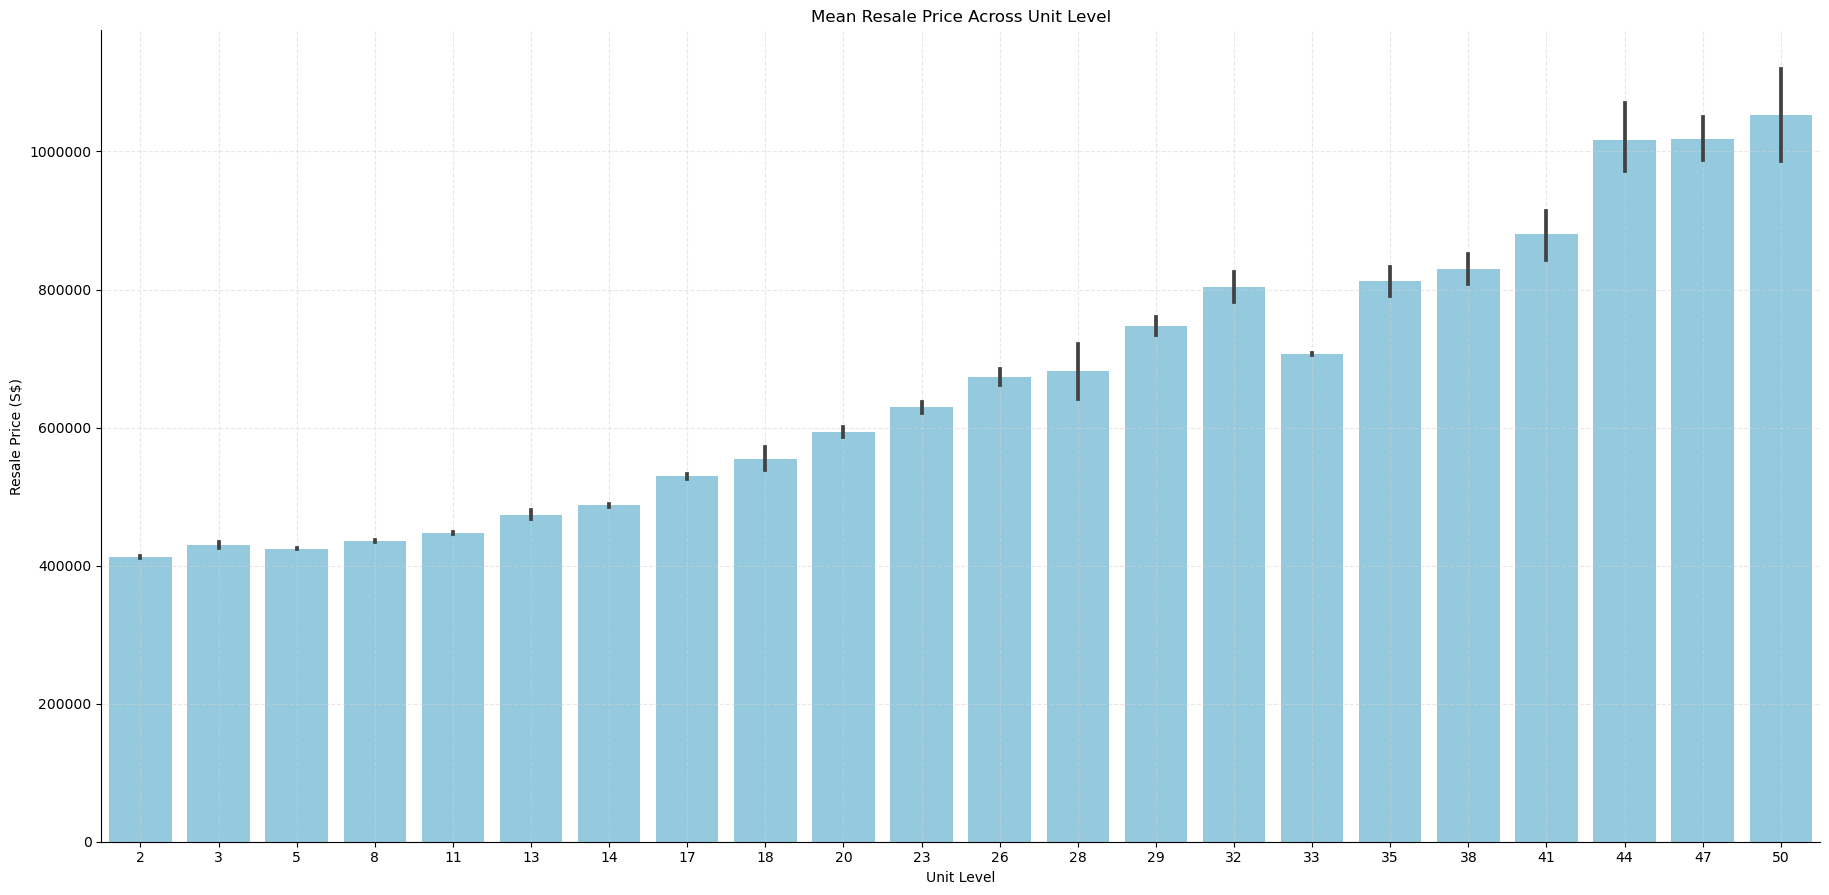

In [50]:

sns.catplot(data=hdb, x='mid_storey', y='resale_price', kind='bar', color='skyblue', height=9, aspect=2)

plt.title('Mean Resale Price Across Unit Level')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Unit Level')
# tick_positions = plt.xticks()[0]
# tick_labels = hdb['town'].unique()
# plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)

### Relationship between resale price/floor area and flat type

In general, there is a positive relationship between resale price and flat type. The average resale price increases with each 'level' of flat type. 
<br>This could because the average floor area increases with each 'level' of flat type.

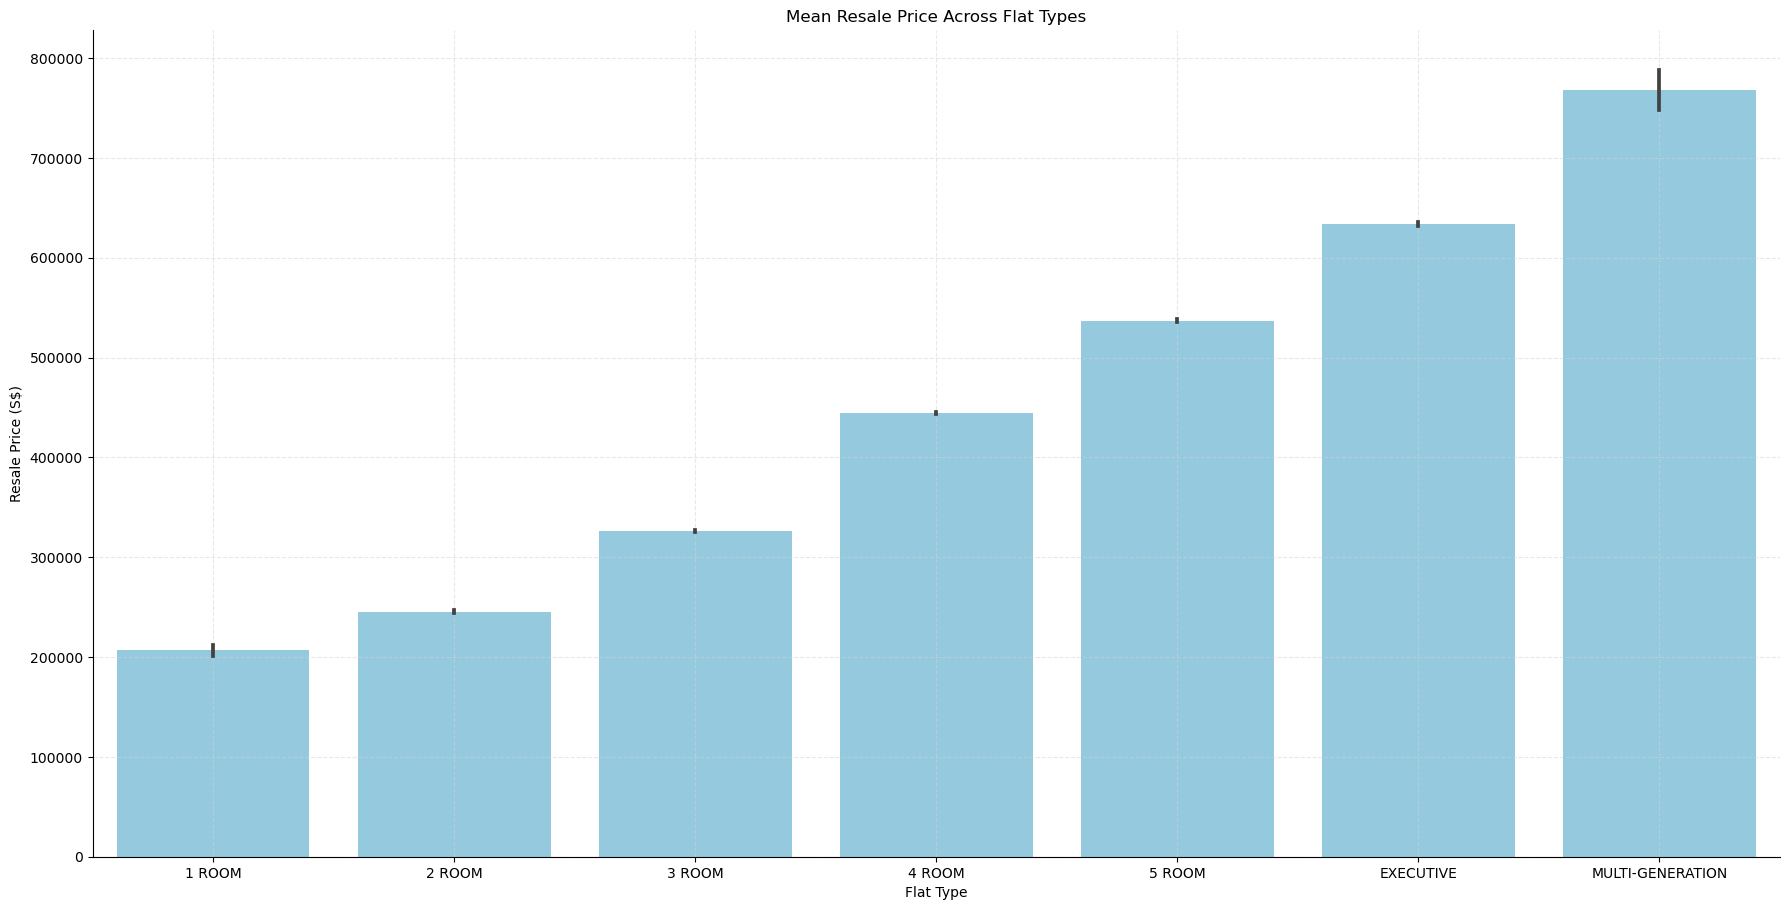

In [51]:

flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
sns.catplot(data=hdb, x='flat_type', y='resale_price', kind='bar', color='skyblue', order = flat_order, height=9, aspect=2)

plt.title('Mean Resale Price Across Flat Types')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Flat Type')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)

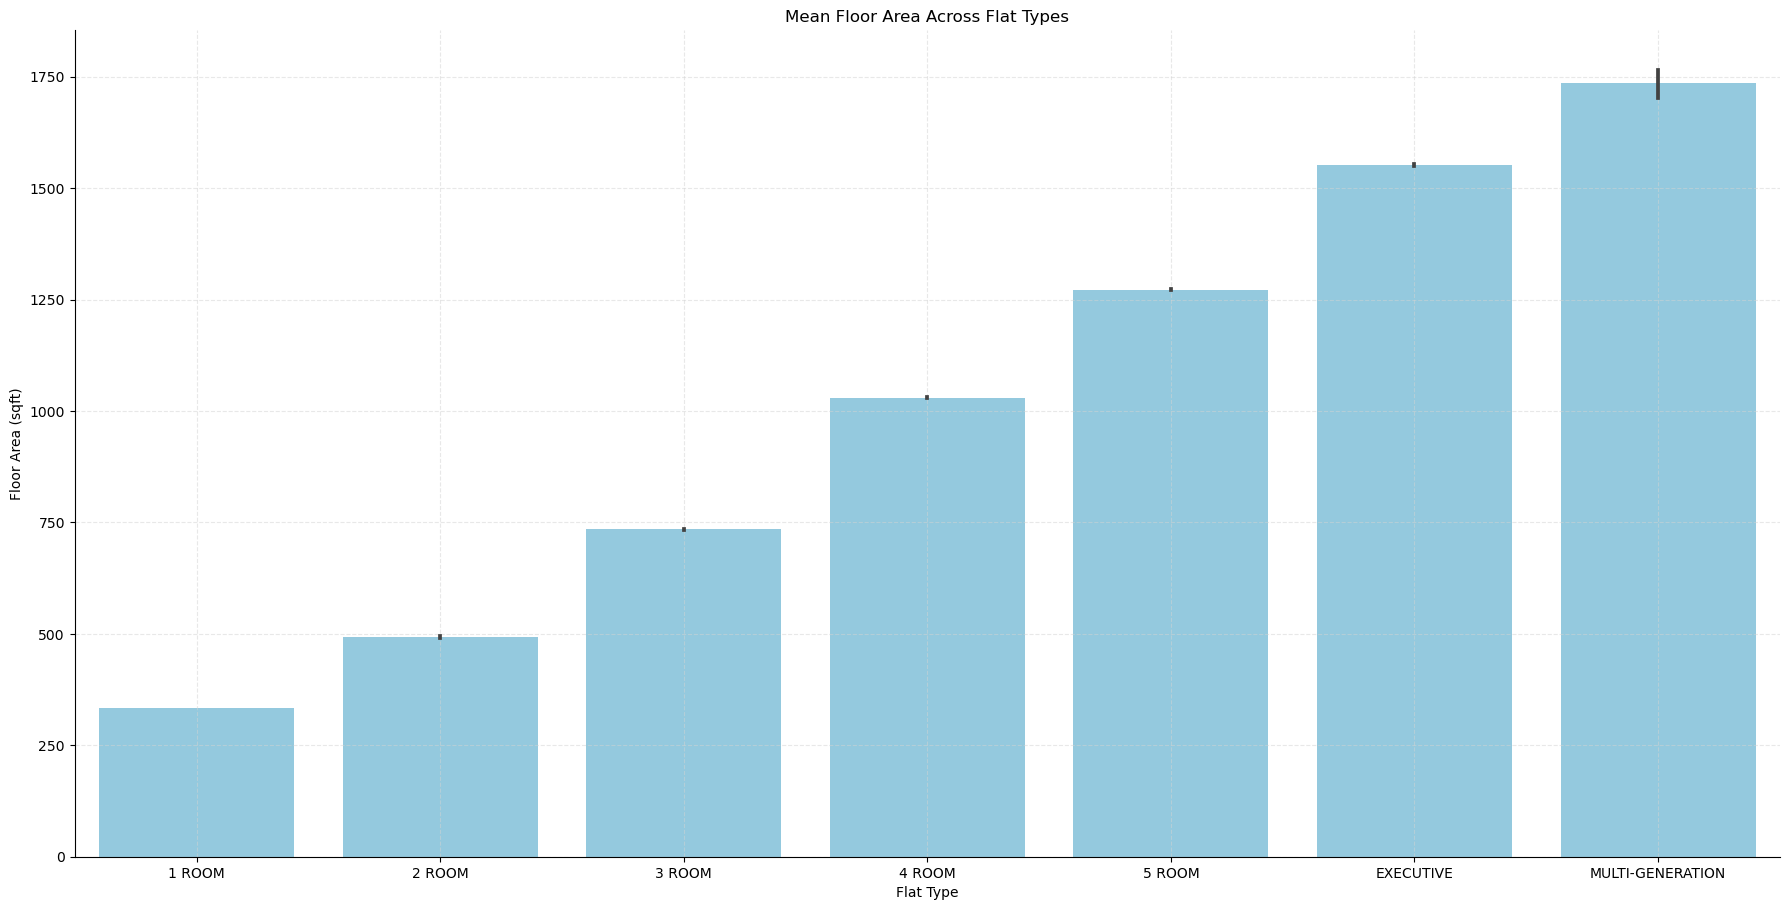

In [52]:

flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
sns.catplot(data=hdb, x='flat_type', y='floor_area_sqft', kind='bar', color='skyblue', order = flat_order, height=9, aspect=2)

plt.title('Mean Floor Area Across Flat Types')
plt.ylabel('Floor Area (sqft)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Flat Type')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)

### Relationship between HDB age at transaction and resale price

In general, the older the HDB is at the time of transaction, the lower the average resale price.
<br> However, there is a large difference between the average resale price of units between 1-2 years old and between 3-5 years old.
<br> In Singapore, most HDB units can only be sold after the minimum occupation period of 5 years. The high average resale price of units between 1-2 years old could be accounted for given there are not many units that are sold at that age (total of only 100 units). While the lower average resale price of units between 3-5 years old could be because units between this age can only be sold with special dispensation by the government, such as when unfortunate events occur (eg. divorce, death of breadwinner, etc.). The occupiers would be unlikely to hold out for higher prices in these cases.

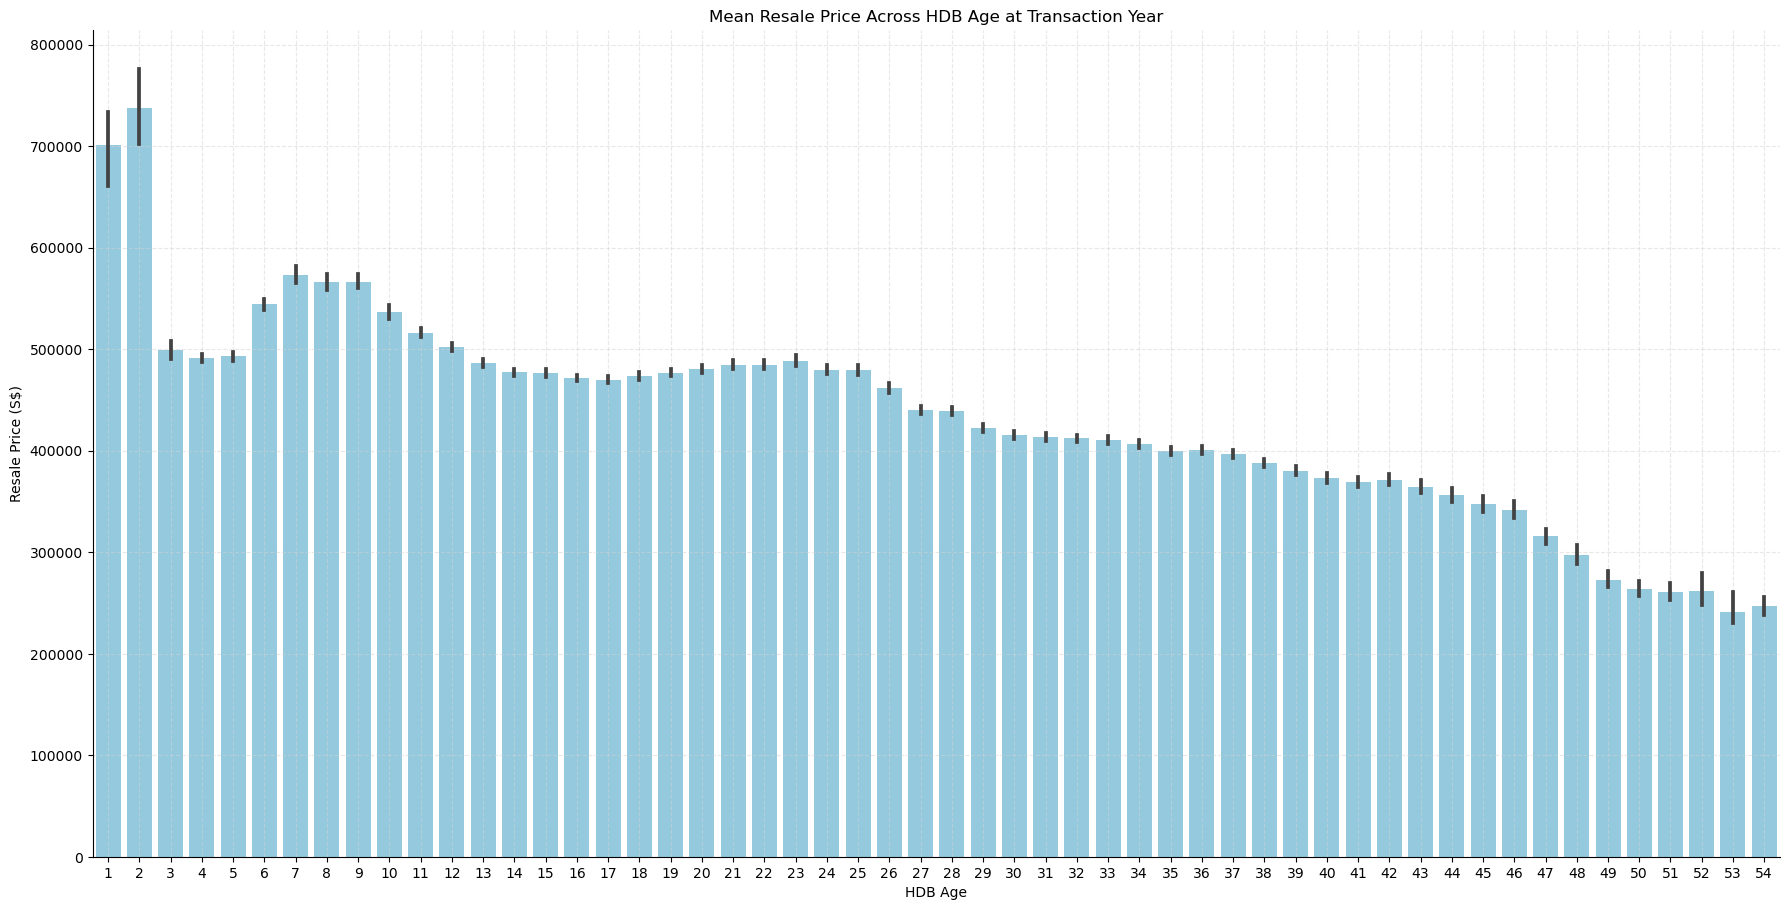

In [53]:

sns.catplot(data=hdb, x='age_at_tranc', y='resale_price', kind='bar', color='skyblue', height=9, aspect=2)

plt.title('Mean Resale Price Across HDB Age at Transaction Year')
plt.ylabel('Resale Price (S$)')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('HDB Age')

plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


### Correlation calculation between all variables

In [54]:
# pearson correlation

hdb_corr = hdb.corr(numeric_only=True)

In [55]:
# mask to show only values that are of interest

corr_mask = hdb_corr[(hdb_corr > 0.3) | (hdb_corr < -0.3)]
tri_mask = np.triu(np.ones_like(hdb_corr))

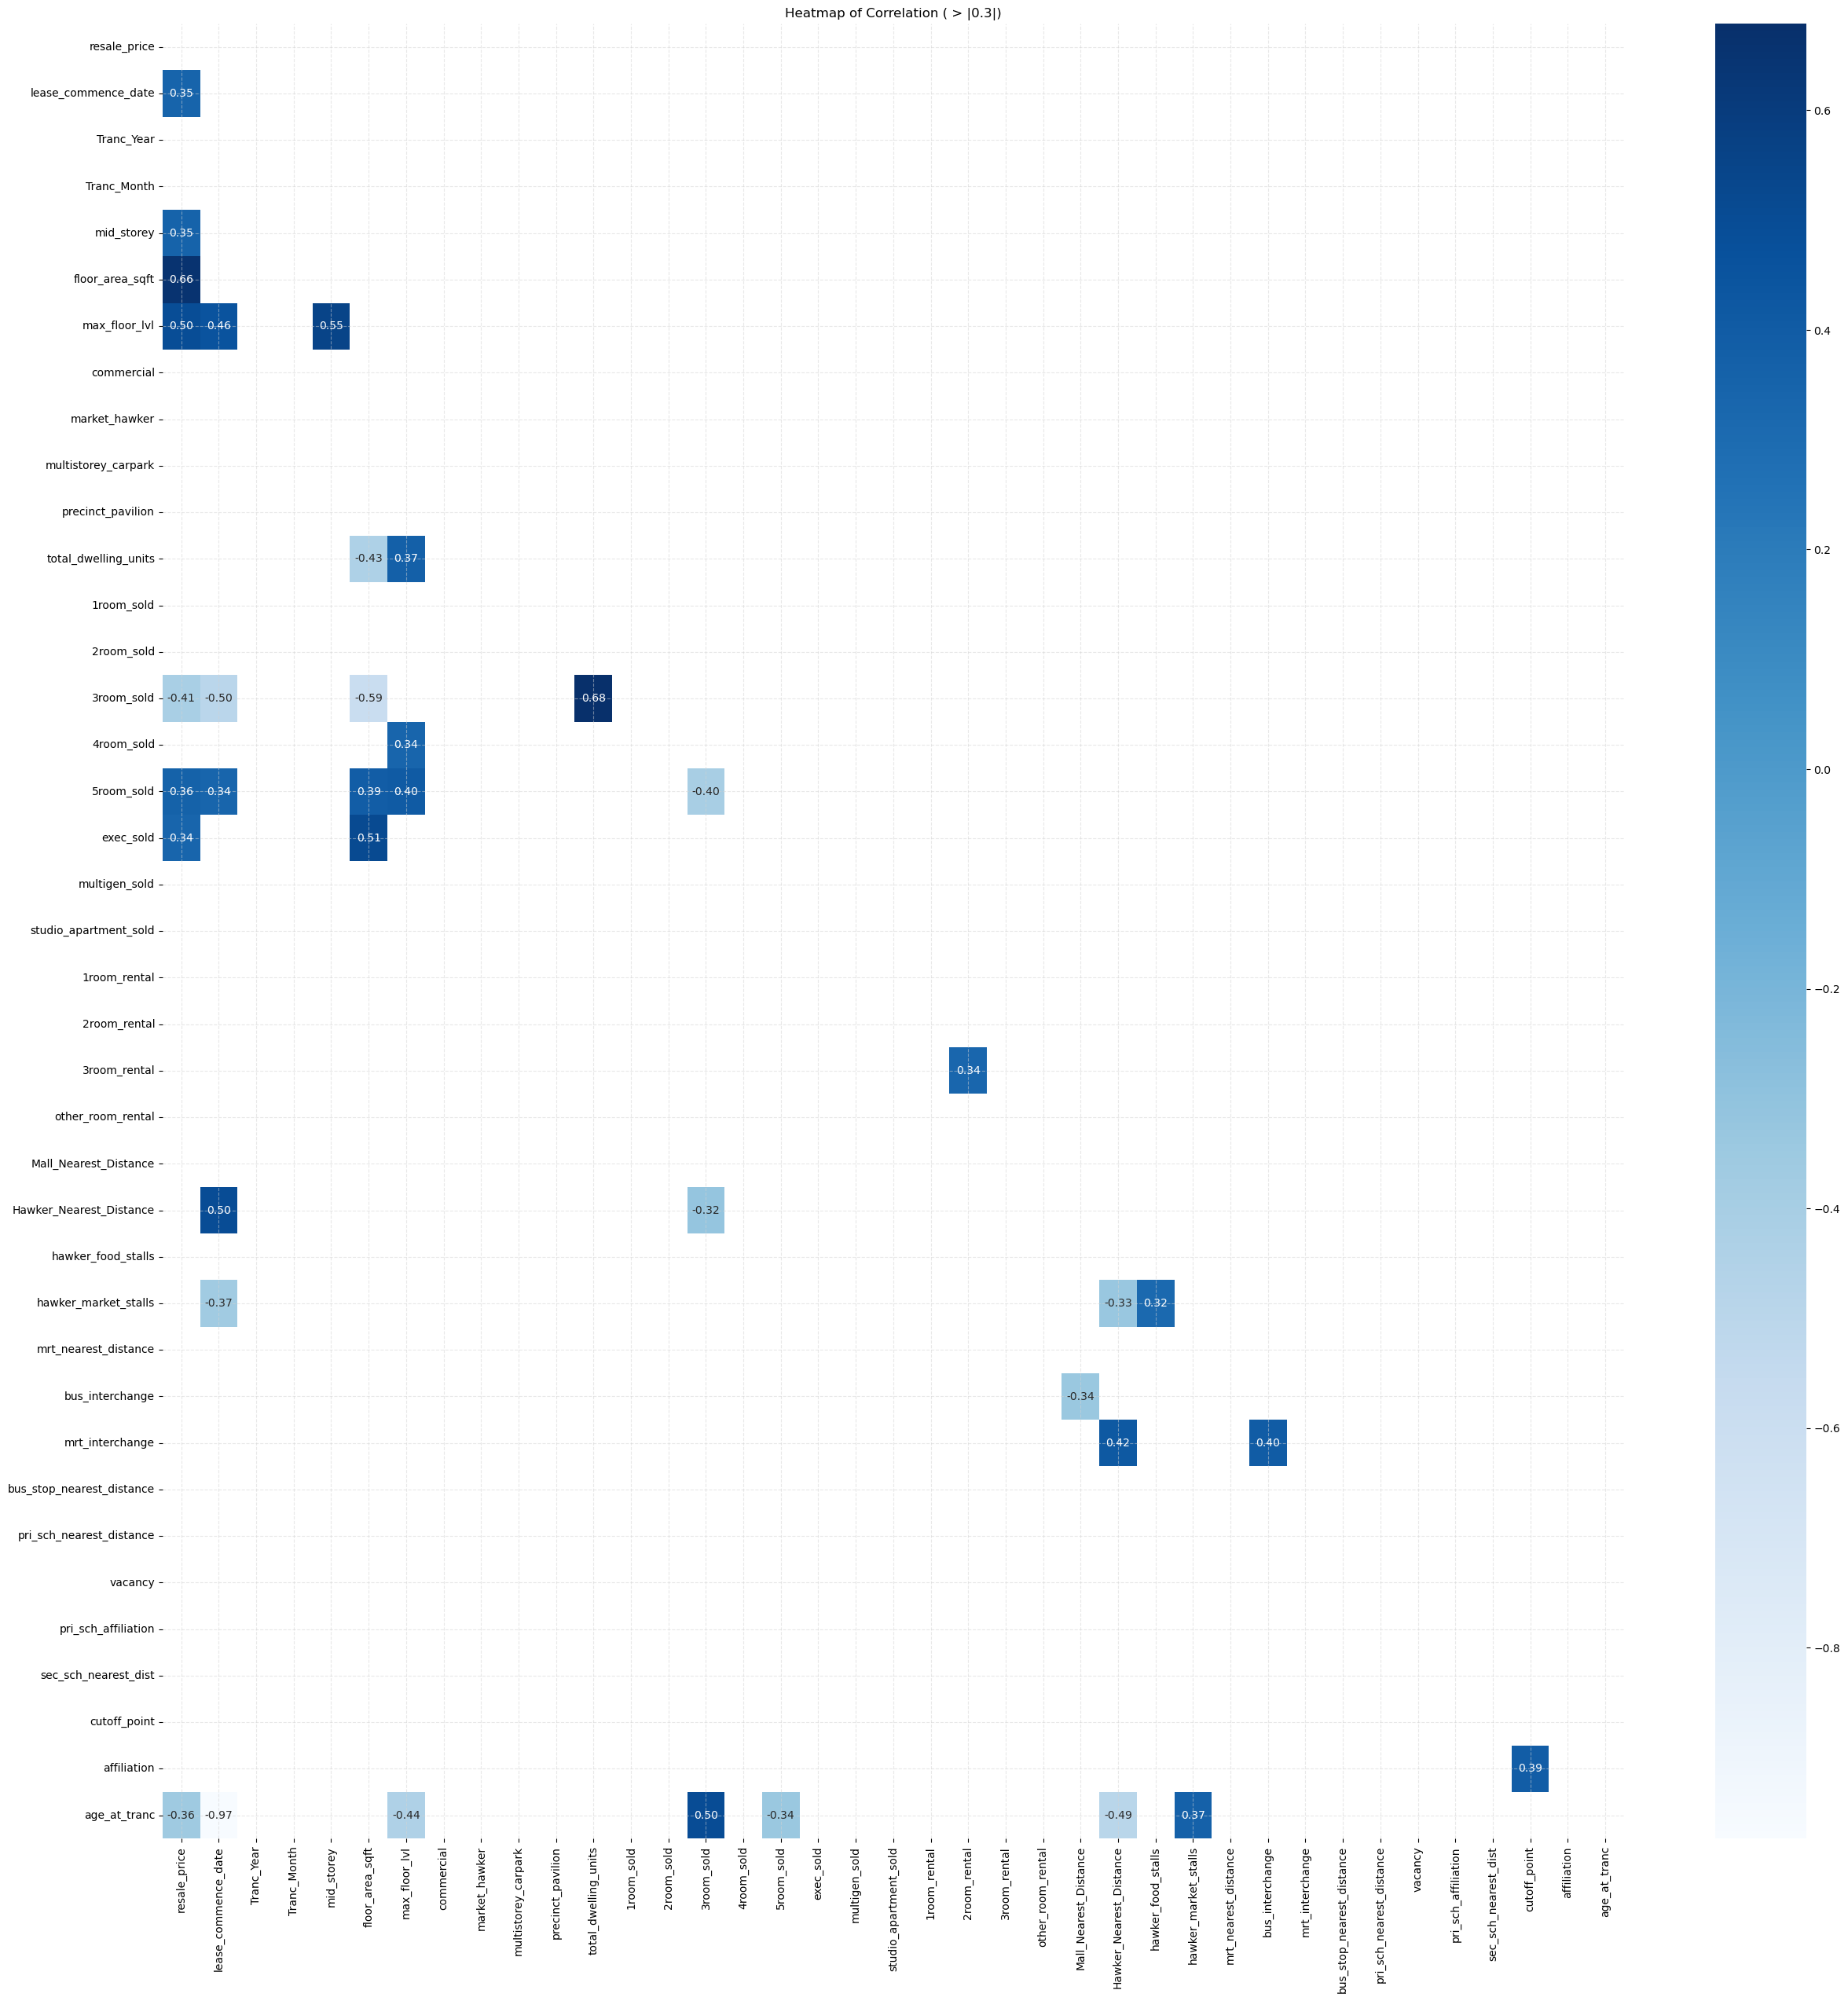

In [56]:
# correlation heatmap for numeric variables

plt.figure(figsize=(30,30))
sns.heatmap(corr_mask, mask = tri_mask, annot=True, fmt='0.2f', cmap='Blues').set(title='Heatmap of Correlation ( > |0.3|)');
plt.grid(True, linestyle='dashed', color='lightgray', alpha=0.5)


The variables with the strongest correlation with resale price (over 50%) are:
1. Floor area, with a correlation coefficient of 0.66
2. Building height, with a correlation coefficient of 0.5

There is also a very strong correlation between HDB age at the year of transaction and the lease commence date. Their correlation coefficient is 0.97, which suggests multicollinearity. One of the two columns should be dropped when prepping the feature matrix.